CHECK GPU AVAILABILITY

In [3]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("CUDA available:", tf.test.is_built_with_cuda())
print("GPU devices:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.10.1
CUDA available: True
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


LOAD CVC MUSCIMA DATASET DATA

In [1]:
import os
import numpy as np
from PIL import Image

def get_cvc_data_paths(dataset_path):
    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"{dataset_path} not found, download the dataset first.")
    
    dirs = ["curvature", "ideal", "interrupted", "kanungo", "rotated", "staffline-thickness-variation-v1",
        "staffline-thickness-variation-v2", "staffline-y-variation-v1", "staffline-y-variation-v2",
        "thickness-ratio", "typeset-emulation", "whitespeckles"]

    data = []
    for dd in dirs:
        dir_path = os.path.join(dataset_path, dd)
        if not os.path.exists(dir_path):
            print(f"Warning: {dir_path} does not exist. Skipping.")
            continue
        folders = os.listdir(dir_path)
        for folder in folders:
            data_path = os.path.join(dir_path, folder)
            image_dir = os.path.join(data_path, "image")
            if not os.path.exists(image_dir):
                print(f"Warning: {image_dir} does not exist. Skipping.")
                continue
            imgs = os.listdir(image_dir)
            for img in imgs:
                img_path = os.path.join(image_dir, img)
                staffline = os.path.join(data_path, "gt", img)
                if os.path.exists(img_path) and os.path.exists(staffline):
                    data.append([img_path, staffline])

    return data

dataset_path = "CvcMuscima-Distortions"
# Create train/val splits
data_paths = get_cvc_data_paths(dataset_path)
np.random.shuffle(data_paths)
split = int(0.8 * len(data_paths))
train_paths = data_paths[:split]
val_paths = data_paths[split:]

print(f"Number of training paths: {len(train_paths)}")
print(f"Number of validation paths: {len(val_paths)}")


Number of training paths: 9600
Number of validation paths: 2400


Focal Tversky Loss Training Code


In [ ]:
# Import required libraries
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.backend as K
import numpy as np
from PIL import Image
import os
import math
import matplotlib.pyplot as plt
import random
import cv2

# Check for GPU availability and configure
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print('GPU is available and configured')
else:
    print('No GPU found, running on CPU')
    
def dice_coef(y_true, y_pred, smooth=1.0):
    """
    Calculate Dice coefficient for segmentation evaluation.
    Range: 0 (no overlap) to 1 (perfect overlap)
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1.0):
    """
    Calculate Intersection over Union (IoU) coefficient for segmentation evaluation.
    Also known as Jaccard Index.
    Range: 0 (no overlap) to 1 (perfect overlap)
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)
    
def dice_loss(y_true, y_pred):
    """
    Dice loss for binary segmentation.
    Modified to penalize false positives more heavily.
    """
    smooth = 1.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    
    # Add penalty for false positives
    false_positives = K.sum((1 - y_true_f) * y_pred_f)
    fp_weight = 2.0  # Weight for false positive penalty
    
    dice = (2.0 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    fp_penalty = false_positives / (K.sum(1 - y_true_f) + smooth)
    
    return 1.0 - dice + fp_weight * fp_penalty

def weighted_dice_loss(y_true, y_pred):
    """
    Weighted Dice loss for binary segmentation with class imbalance handling.
    """
    smooth = 1.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    pos_weight = 10.0  # Weight for positive class (staff lines)
    neg_weight = 1.0   # Weight for negative class (background)
    
    # Apply weights
    weighted_y_true = y_true_f * pos_weight + (1 - y_true_f) * neg_weight
    
    intersection = K.sum(y_true_f * y_pred_f * weighted_y_true)
    union = K.sum(y_true_f * weighted_y_true) + K.sum(y_pred_f * weighted_y_true)
    
    dice = (2.0 * intersection + smooth) / (union + smooth)
    
    return 1.0 - dice

def tversky_loss(y_true, y_pred, alpha=0.8, beta=0.2, smooth=1.0):
    """
    Tversky loss for imbalanced data.
    alpha: controls false negatives weight
    beta: controls false positives weight
    When alpha > beta, the model is penalized more for false negatives
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    # True positives, false negatives, false positives
    tp = K.sum(y_true_f * y_pred_f)
    fn = K.sum(y_true_f * (1 - y_pred_f))
    fp = K.sum((1 - y_true_f) * y_pred_f)
    
    tversky = (tp + smooth) / (tp + alpha * fn + beta * fp + smooth)
    
    return 1 - tversky

def focal_tversky_loss(y_true, y_pred, alpha=0.8, beta=0.2, gamma=1.5, smooth=1.0):
    """
    Focal Tversky loss to focus more on hard examples.
    gamma: focusing parameter that reduces the loss contribution from easy examples
    """
    tv = tversky_loss(y_true, y_pred, alpha, beta, smooth)
    return K.pow(tv, gamma)

def build_unet(input_size=(256, 256, 1)):
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    conv3 = Dropout(0.3)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(conv4)
    conv4 = tf.keras.layers.BatchNormalization()(conv4)
    conv4 = Dropout(0.3)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Deepest Encoder Layer (512 filters)
    conv5 = Conv2D(512, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same')(conv5)
    conv5 = tf.keras.layers.BatchNormalization()(conv5)
    conv5 = Dropout(0.4)(conv5)  # Slightly higher dropout
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)

    # Bridge
    conv6 = Conv2D(1024, 3, activation='relu', padding='same')(pool5)
    conv6 = Conv2D(1024, 3, activation='relu', padding='same')(conv6)
    conv6 = tf.keras.layers.BatchNormalization()(conv6)
    drop6 = Dropout(0.4)(conv6)

    # Decoder
    up7 = Conv2DTranspose(512, 2, strides=(2,2), padding='same')(drop6)
    merge7 = concatenate([conv5, up7])
    conv7 = Conv2D(512, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(512, 3, activation='relu', padding='same')(conv7)
    conv7 = tf.keras.layers.BatchNormalization()(conv7)
    conv7 = Dropout(0.4)(conv7)
    
    up8 = Conv2DTranspose(256, 2, strides=(2,2), padding='same')(conv7)
    merge8 = concatenate([conv4, up8])
    conv8 = Conv2D(256, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(256, 3, activation='relu', padding='same')(conv8)
    conv8 = tf.keras.layers.BatchNormalization()(conv8)
    conv8 = Dropout(0.3)(conv8)

    up9 = Conv2DTranspose(128, 2, strides=(2,2), padding='same')(conv8)
    merge9 = concatenate([conv3, up9])
    conv9 = Conv2D(128, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(128, 3, activation='relu', padding='same')(conv9)
    conv9 = tf.keras.layers.BatchNormalization()(conv9)
    conv9 = Dropout(0.3)(conv9)

    up10 = Conv2DTranspose(64, 2, strides=(2,2), padding='same')(conv9)
    merge10 = concatenate([conv2, up10])
    conv10 = Conv2D(64, 3, activation='relu', padding='same')(merge10)
    conv10 = Conv2D(64, 3, activation='relu', padding='same')(conv10)
    conv10 = tf.keras.layers.BatchNormalization()(conv10)
    conv10 = Dropout(0.3)(conv10)

    up11 = Conv2DTranspose(32, 2, strides=(2,2), padding='same')(conv10)
    merge11 = concatenate([conv1, up11])
    conv11 = Conv2D(32, 3, activation='relu', padding='same')(merge11)
    conv11 = Conv2D(32, 3, activation='relu', padding='same')(conv11)
    conv11 = tf.keras.layers.BatchNormalization()(conv11)

    # Final layer with lower initial bias to prevent class imbalance
    outputs = Conv2D(1, 1, activation='sigmoid', bias_initializer=tf.keras.initializers.Constant(-2.0))(conv11)

    model = Model(inputs=inputs, outputs=outputs)
    return model


def get_sliding_chunks(img_array, chunk_size=(256, 256), stride=128):
    """Get all possible sliding window chunks from image with given stride"""
    height, width = img_array.shape
    chunks = []
    positions = []
    
    for h in range(0, height - chunk_size[0] + 1, stride):
        for w in range(0, width - chunk_size[1] + 1, stride):
            chunk = img_array[h:h + chunk_size[0], w:w + chunk_size[1]]
            chunks.append(chunk)
            positions.append((h, w))
            
    # Handle edge cases
    # Right edge
    if width % stride != 0:
        for h in range(0, height - chunk_size[0] + 1, stride):
            w = width - chunk_size[1]
            chunk = img_array[h:h + chunk_size[0], w:w + chunk_size[1]]
            chunks.append(chunk)
            positions.append((h, w))
            
    # Bottom edge
    if height % stride != 0:
        for w in range(0, width - chunk_size[1] + 1, stride):
            h = height - chunk_size[0]
            chunk = img_array[h:h + chunk_size[0], w:w + chunk_size[1]]
            chunks.append(chunk)
            positions.append((h, w))
            
    # Bottom-right corner
    if height % stride != 0 and width % stride != 0:
        h = height - chunk_size[0]
        w = width - chunk_size[1]
        chunk = img_array[h:h + chunk_size[0], w:w + chunk_size[1]]
        chunks.append(chunk)
        positions.append((h, w))
    
    return chunks, positions

def preprocess_data_generator(data_paths, batch_size=16, chunk_size=(256, 256), stride=128):
    while True:
        np.random.shuffle(data_paths)
        
        X_batch = []
        y_batch = []
        
        for img_path, staff_path in data_paths:
            img = Image.open(img_path).convert('L')
            staff = Image.open(staff_path).convert('L')
            
            #img = resize_image_with_augmentation(img)
            staff = staff.resize(img.size)
            
            # Contrast Enhancement
            img_array = np.array(img)
            img_array = cv2.equalizeHist(img_array)
            img = Image.fromarray(img_array)
            
            img = np.array(img) / 255.0
            staff = (np.array(staff) > 128).astype(np.float32)
            
            img_chunks, positions = get_sliding_chunks(img, chunk_size, stride)
            staff_chunks, _ = get_sliding_chunks(staff, chunk_size, stride)
            
            # Visualize Chunks during training if needed
            if random.random() < 0.00:
                plt.figure(figsize=(12, 4))
                for i in range(min(9, len(img_chunks))):
                    plt.subplot(1, 9, i+1)
                    plt.imshow(img_chunks[i], cmap='gray')
                    h, w = positions[i]
                    plt.title(f'({h},{w})', fontsize=8)
                    plt.axis('off')
                plt.tight_layout()
                plt.show()
            
            for img_chunk, staff_chunk in zip(img_chunks, staff_chunks):
                # Try to remove completely black chunks
                if np.mean(staff_chunk) > 0.01:  # At least 1% staffline pixels
                    X_batch.append(img_chunk)
                    y_batch.append(staff_chunk)
                
                if len(X_batch) == batch_size:
                    yield (np.array(X_batch)[..., np.newaxis],
                          np.array(y_batch)[..., np.newaxis])
                    X_batch = []
                    y_batch = []
            
            # Check partial batch at the end of each image
            if len(X_batch) > 0:
                yield (np.array(X_batch)[..., np.newaxis],
                      np.array(y_batch)[..., np.newaxis])
                X_batch = []
                y_batch = []

print("Starting training process...")

# Training parameters
BATCH_SIZE = 16  
STRIDE = 256  # Stride the same as the chunk size to remove overlapping chunks
MAX_IMAGES_PER_EPOCH = 200  
VALIDATION_IMAGES = 200 

train_generator = preprocess_data_generator(
    train_paths, 
    BATCH_SIZE,
    chunk_size=(256, 256), 
    stride=STRIDE
)
val_generator = preprocess_data_generator(
    val_paths, 
    BATCH_SIZE,
    chunk_size=(256, 256),
    stride=STRIDE
)

AVG_IMAGE_SIZE = (1750, 1250)  
CHUNKS_PER_IMAGE = ((AVG_IMAGE_SIZE[0] - 256) // STRIDE + 1) * ((AVG_IMAGE_SIZE[1] - 256) // STRIDE + 1)

STEPS_PER_EPOCH = (CHUNKS_PER_IMAGE * MAX_IMAGES_PER_EPOCH) // BATCH_SIZE
VALIDATION_STEPS = (CHUNKS_PER_IMAGE * VALIDATION_IMAGES) // BATCH_SIZE

print(f"Estimated chunks per image: {CHUNKS_PER_IMAGE}")
print(f"Steps per epoch: {STEPS_PER_EPOCH}")
print(f"Validation steps: {VALIDATION_STEPS}")

print("\nBuilding U-Net model...")
unet_model = build_unet(input_size=(256, 256, 1))
unet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=focal_tversky_loss,
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), dice_coef, iou_coef]
)

print("\nSetting up callbacks...")
class MetricsPrinter(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"\nEpoch {epoch+1}:")
        for metric, value in logs.items():
            print(f"{metric}: {value:.4f}")

checkpoint = ModelCheckpoint(
    'test_unet_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=1,
    min_lr=1e-6,
    verbose=1
)

metrics_printer = MetricsPrinter()

callbacks = [checkpoint, early_stopping, reduce_lr, metrics_printer]

print("\nStarting model training...")
print("Training will run for 15 epochs with early stopping...")
history = unet_model.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    epochs=15,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")
print("Saving final model...")
unet_model.save('finaltest_unet_modelweighted500DICE.h5')
print("Model saved successfully as 'final_unet_modelweighted500DICE.h5'")


DICE LOSS AND REDUCED MODEL LAYERS (Additional Filtering For Empty Chunks) 

In [ ]:
# Import required libraries
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.backend as K
import numpy as np
from PIL import Image
import os
import math
import matplotlib.pyplot as plt
import random
import cv2
# Check for GPU availability and configure
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print('GPU is available and configured')
else:
    print('No GPU found, running on CPU')
    
def dice_loss(y_true, y_pred):
    """
    Dice loss for binary segmentation.
    Modified to penalize false positives more heavily.
    """
    smooth = 1.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    
    # Add penalty term for false positives
    false_positives = K.sum((1 - y_true_f) * y_pred_f)
    fp_weight = 2.0  # Weight for false positive penalty
    
    dice = (2.0 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    fp_penalty = false_positives / (K.sum(1 - y_true_f) + smooth)
    
    return 1.0 - dice + fp_weight * fp_penalty

def weighted_dice_loss(y_true, y_pred):
    """
    Weighted Dice loss for binary segmentation with class imbalance handling.
    """
    smooth = 1.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    # Calculate class weights based on frequency
    pos_weight = 10.0  # Weight for positive class (staff lines)
    neg_weight = 1.0   # Weight for negative class (background)
    
    # Apply weights
    weighted_y_true = y_true_f * pos_weight + (1 - y_true_f) * neg_weight
    
    intersection = K.sum(y_true_f * y_pred_f * weighted_y_true)
    union = K.sum(y_true_f * weighted_y_true) + K.sum(y_pred_f * weighted_y_true)
    
    dice = (2.0 * intersection + smooth) / (union + smooth)
    
    return 1.0 - dice

def build_unet(input_size=(256, 256, 1)):  # Reduced input size
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    conv3 = Dropout(0.3)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    # Bridge
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(conv4)
    conv4 = tf.keras.layers.BatchNormalization()(conv4)
    drop4 = Dropout(0.3)(conv4)  # Increased dropout rate
    
    # Decoder
    up5 = Conv2DTranspose(128, 2, strides=(2,2), padding='same')(drop4)
    merge5 = concatenate([conv3, up5])
    conv5 = Conv2D(128, 3, activation='relu', padding='same')(merge5)
    conv5 = Conv2D(128, 3, activation='relu', padding='same')(conv5)
    conv5 = tf.keras.layers.BatchNormalization()(conv5)
    conv5 = Dropout(0.3)(conv5) 
    
    up6 = Conv2DTranspose(64, 2, strides=(2,2), padding='same')(conv5)
    merge6 = concatenate([conv2, up6])
    conv6 = Conv2D(64, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(64, 3, activation='relu', padding='same')(conv6)
    conv6 = tf.keras.layers.BatchNormalization()(conv6)
    conv6 = Dropout(0.3)(conv6)
    
    up7 = Conv2DTranspose(32, 2, strides=(2,2), padding='same')(conv6)
    merge7 = concatenate([conv1, up7])
    conv7 = Conv2D(32, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(32, 3, activation='relu', padding='same')(conv7)
    conv7 = tf.keras.layers.BatchNormalization()(conv7)
    
    # Final layer with lower initial bias
    outputs = Conv2D(1, 1, activation='sigmoid', bias_initializer=tf.keras.initializers.Constant(-2.0))(conv7)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

def get_sliding_chunks(img_array, chunk_size=(256, 256), stride=128):
    """Get all possible sliding window chunks from image with given stride"""
    height, width = img_array.shape
    chunks = []
    positions = []
    
    for h in range(0, height - chunk_size[0] + 1, stride):
        for w in range(0, width - chunk_size[1] + 1, stride):
            chunk = img_array[h:h + chunk_size[0], w:w + chunk_size[1]]
            chunks.append(chunk)
            positions.append((h, w))
            
    # Handle edge cases
    # Right edge
    if width % stride != 0:
        for h in range(0, height - chunk_size[0] + 1, stride):
            w = width - chunk_size[1]
            chunk = img_array[h:h + chunk_size[0], w:w + chunk_size[1]]
            chunks.append(chunk)
            positions.append((h, w))
            
    # Bottom edge
    if height % stride != 0:
        for w in range(0, width - chunk_size[1] + 1, stride):
            h = height - chunk_size[0]
            chunk = img_array[h:h + chunk_size[0], w:w + chunk_size[1]]
            chunks.append(chunk)
            positions.append((h, w))
            
    # Bottom-right corner
    if height % stride != 0 and width % stride != 0:
        h = height - chunk_size[0]
        w = width - chunk_size[1]
        chunk = img_array[h:h + chunk_size[0], w:w + chunk_size[1]]
        chunks.append(chunk)
        positions.append((h, w))
    
    return chunks, positions

def preprocess_data_generator(data_paths, batch_size=16, chunk_size=(256, 256), stride=128):
    while True:
        np.random.shuffle(data_paths)
        
        X_batch = []
        y_batch = []
        
        for img_path, staff_path in data_paths:
            # Load and resize images
            img = Image.open(img_path).convert('L')
            staff = Image.open(staff_path).convert('L')
            
            #img = resize_image_with_augmentation(img)
            staff = staff.resize(img.size)
            
            # Apply contrast enhancement to input images
            img_array = np.array(img)
            img_array = cv2.equalizeHist(img_array)
            img = Image.fromarray(img_array)
            
            img = np.array(img) / 255.0
            staff = (np.array(staff) > 128).astype(np.float32)
            
            img_chunks, positions = get_sliding_chunks(img, chunk_size, stride)
            staff_chunks, _ = get_sliding_chunks(staff, chunk_size, stride)
            
            # Reduced visualization frequency
            if random.random() < 0.00:  # Show chunks 5% of the time
                plt.figure(figsize=(12, 4))
                for i in range(min(9, len(img_chunks))):
                    plt.subplot(1, 9, i+1)
                    plt.imshow(img_chunks[i], cmap='gray')
                    h, w = positions[i]
                    plt.title(f'({h},{w})', fontsize=8)
                    plt.axis('off')
                plt.tight_layout()
                plt.show()
            
            for img_chunk, staff_chunk in zip(img_chunks, staff_chunks):
                # Only add chunks that contain actual staff lines (reduce empty chunks)
                if np.mean(staff_chunk) > 0.01:  # At least 1% staffline pixels
                    X_batch.append(img_chunk)
                    y_batch.append(staff_chunk)
                
                if len(X_batch) == batch_size:
                    yield (np.array(X_batch)[..., np.newaxis],
                          np.array(y_batch)[..., np.newaxis])
                    X_batch = []
                    y_batch = []
            
            # Check if we have a partial batch at the end of each image
            # This ensures we don't lose data between images
            if len(X_batch) > 0:
                yield (np.array(X_batch)[..., np.newaxis],
                      np.array(y_batch)[..., np.newaxis])
                X_batch = []
                y_batch = []

print("Starting training process...")

# Training parameters - reduced for faster training
BATCH_SIZE = 16  # Increased batch size
STRIDE = 128  # Reduced stride
MAX_IMAGES_PER_EPOCH = 100  # Reduced images per epoch
VALIDATION_IMAGES = 150  # Reduced validation images

train_generator = preprocess_data_generator(
    train_paths, 
    BATCH_SIZE,
    chunk_size=(256, 256),  # Reduced chunk size
    stride=STRIDE
)
val_generator = preprocess_data_generator(
    val_paths, 
    BATCH_SIZE,
    chunk_size=(256, 256),
    stride=STRIDE
)

# Calculate average number of chunks per image based on smaller image size
AVG_IMAGE_SIZE = (1750, 1250)  # Reduced typical size
CHUNKS_PER_IMAGE = ((AVG_IMAGE_SIZE[0] - 256) // STRIDE + 1) * ((AVG_IMAGE_SIZE[1] - 256) // STRIDE + 1)

STEPS_PER_EPOCH = (CHUNKS_PER_IMAGE * MAX_IMAGES_PER_EPOCH) // BATCH_SIZE
VALIDATION_STEPS = (CHUNKS_PER_IMAGE * VALIDATION_IMAGES) // BATCH_SIZE

print(f"Estimated chunks per image: {CHUNKS_PER_IMAGE}")
print(f"Steps per epoch: {STEPS_PER_EPOCH}")
print(f"Validation steps: {VALIDATION_STEPS}")

print("\nBuilding U-Net model...")
unet_model = build_unet(input_size=(256, 256, 1))  # Reduced input size
unet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  
    loss=weighted_dice_loss,
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

print("\nSetting up callbacks...")
class MetricsPrinter(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"\nEpoch {epoch+1}:")
        for metric, value in logs.items():
            print(f"{metric}: {value:.4f}")

checkpoint = ModelCheckpoint(
    'test_unet_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=1,  # Reduced patience
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=1,  # Reduced patience
    min_lr=1e-6,
    verbose=1
)

metrics_printer = MetricsPrinter()

callbacks = [checkpoint, early_stopping, reduce_lr, metrics_printer]

print("\nStarting model training...")
print("Training will run for 15 epochs with early stopping...")
history = unet_model.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    epochs=15,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")
print("Saving final model...")
unet_model.save('finaltest_unet_modelweighted.h5')
print("Model saved successfully as 'final_unet_modelweighted.h5'")


GPU is available and configured
Starting training process...
Estimated chunks per image: 96
Steps per epoch: 600
Validation steps: 900

Building U-Net model...

Setting up callbacks...

Starting model training...
Training will run for 15 epochs with early stopping...
Epoch 1/15
600/600 [==============================] - ETA: 0s - loss: 0.0741 - accuracy: 0.9655 - precision_1: 0.7566 - recall_1: 0.9752Batch stats: 10 non-empty chunks, 44 empty chunks skipped
Batch stats: 174 non-empty chunks, 33 empty chunks skipped
Batch stats: 396 non-empty chunks, 43 empty chunks skipped
Batch stats: 77 non-empty chunks, 47 empty chunks skipped
Batch stats: 156 non-empty chunks, 79 empty chunks skipped

Epoch 1: val_loss improved from inf to 0.03348, saving model to test_unet_model.h5

Epoch 1:
loss: 0.0741
accuracy: 0.9655
precision_1: 0.7566
recall_1: 0.9752
val_loss: 0.0335
val_accuracy: 0.9827
val_precision_1: 0.8640
val_recall_1: 0.9906
lr: 0.0001
600/600 [==============================] - 267s 

DEEPER U-NET MODEL WITH TVERSKY LOSS

In [10]:
# Import required libraries
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.backend as K
import numpy as np
from PIL import Image
import os
import math
import matplotlib.pyplot as plt
import random
import cv2

# Check for GPU availability and configure
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print('GPU is available and configured')
else:
    print('No GPU found, running on CPU')
    
def dice_coef(y_true, y_pred, smooth=1.0):
    """
    Calculate Dice coefficient for segmentation evaluation.
    Range: 0 (no overlap) to 1 (perfect overlap)
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1.0):
    """
    Calculate Intersection over Union (IoU) coefficient for segmentation evaluation.
    Also known as Jaccard Index.
    Range: 0 (no overlap) to 1 (perfect overlap)
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)
    
def dice_loss(y_true, y_pred):
    """
    Dice loss for binary segmentation.
    Modified to penalize false positives more heavily.
    """
    smooth = 1.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    
    # Add penalty term for false positives
    false_positives = K.sum((1 - y_true_f) * y_pred_f)
    fp_weight = 2.0  # Weight for false positive penalty
    
    dice = (2.0 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    fp_penalty = false_positives / (K.sum(1 - y_true_f) + smooth)
    
    return 1.0 - dice + fp_weight * fp_penalty

def weighted_dice_loss(y_true, y_pred):
    """
    Weighted Dice loss for binary segmentation with class imbalance handling.
    """
    smooth = 1.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    # Calculate class weights based on frequency
    pos_weight = 10.0  # Weight for positive class (staff lines)
    neg_weight = 1.0   # Weight for negative class (background)
    
    # Apply weights
    weighted_y_true = y_true_f * pos_weight + (1 - y_true_f) * neg_weight
    
    intersection = K.sum(y_true_f * y_pred_f * weighted_y_true)
    union = K.sum(y_true_f * weighted_y_true) + K.sum(y_pred_f * weighted_y_true)
    
    dice = (2.0 * intersection + smooth) / (union + smooth)
    
    return 1.0 - dice

def tversky_loss(y_true, y_pred, alpha=0.2, beta=0.8, smooth=1.0):
    """
    Tversky loss for imbalanced data.
    alpha: controls false negatives weight
    beta: controls false positives weight
    When alpha > beta, the model is penalized more for false negatives
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    # True positives, false negatives, false positives
    tp = K.sum(y_true_f * y_pred_f)
    fn = K.sum(y_true_f * (1 - y_pred_f))
    fp = K.sum((1 - y_true_f) * y_pred_f)
    
    tversky = (tp + smooth) / (tp + alpha * fn + beta * fp + smooth)
    
    return 1 - tversky

def focal_tversky_loss(y_true, y_pred, alpha=0.2, beta=0.8, gamma=1.5, smooth=1.0):
    """
    Focal Tversky loss to focus more on hard examples.
    gamma: focusing parameter that reduces the loss contribution from easy examples
    """
    tv = tversky_loss(y_true, y_pred, alpha, beta, smooth)
    return K.pow(tv, gamma)

def build_unet(input_size=(256, 256, 1)):  # Adjust input size if needed
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    conv3 = Dropout(0.3)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(conv4)
    conv4 = tf.keras.layers.BatchNormalization()(conv4)
    conv4 = Dropout(0.3)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # New Deeper Encoder Layer (512 filters)
    conv5 = Conv2D(512, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same')(conv5)
    conv5 = tf.keras.layers.BatchNormalization()(conv5)
    conv5 = Dropout(0.4)(conv5)  # Slightly higher dropout
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)

    # Bridge
    conv6 = Conv2D(1024, 3, activation='relu', padding='same')(pool5)
    conv6 = Conv2D(1024, 3, activation='relu', padding='same')(conv6)
    conv6 = tf.keras.layers.BatchNormalization()(conv6)
    drop6 = Dropout(0.4)(conv6)

    # Decoder
    up7 = Conv2DTranspose(512, 2, strides=(2,2), padding='same')(drop6)
    merge7 = concatenate([conv5, up7])
    conv7 = Conv2D(512, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(512, 3, activation='relu', padding='same')(conv7)
    conv7 = tf.keras.layers.BatchNormalization()(conv7)
    conv7 = Dropout(0.4)(conv7)
    
    up8 = Conv2DTranspose(256, 2, strides=(2,2), padding='same')(conv7)
    merge8 = concatenate([conv4, up8])
    conv8 = Conv2D(256, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(256, 3, activation='relu', padding='same')(conv8)
    conv8 = tf.keras.layers.BatchNormalization()(conv8)
    conv8 = Dropout(0.3)(conv8)

    up9 = Conv2DTranspose(128, 2, strides=(2,2), padding='same')(conv8)
    merge9 = concatenate([conv3, up9])
    conv9 = Conv2D(128, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(128, 3, activation='relu', padding='same')(conv9)
    conv9 = tf.keras.layers.BatchNormalization()(conv9)
    conv9 = Dropout(0.3)(conv9)

    up10 = Conv2DTranspose(64, 2, strides=(2,2), padding='same')(conv9)
    merge10 = concatenate([conv2, up10])
    conv10 = Conv2D(64, 3, activation='relu', padding='same')(merge10)
    conv10 = Conv2D(64, 3, activation='relu', padding='same')(conv10)
    conv10 = tf.keras.layers.BatchNormalization()(conv10)
    conv10 = Dropout(0.3)(conv10)

    up11 = Conv2DTranspose(32, 2, strides=(2,2), padding='same')(conv10)
    merge11 = concatenate([conv1, up11])
    conv11 = Conv2D(32, 3, activation='relu', padding='same')(merge11)
    conv11 = Conv2D(32, 3, activation='relu', padding='same')(conv11)
    conv11 = tf.keras.layers.BatchNormalization()(conv11)

    # Final layer with lower initial bias
    outputs = Conv2D(1, 1, activation='sigmoid', bias_initializer=tf.keras.initializers.Constant(-2.0))(conv11)

    model = Model(inputs=inputs, outputs=outputs)
    return model


def get_sliding_chunks(img_array, chunk_size=(256, 256), stride=128):
    """Get all possible sliding window chunks from image with given stride"""
    height, width = img_array.shape
    chunks = []
    positions = []
    
    for h in range(0, height - chunk_size[0] + 1, stride):
        for w in range(0, width - chunk_size[1] + 1, stride):
            chunk = img_array[h:h + chunk_size[0], w:w + chunk_size[1]]
            chunks.append(chunk)
            positions.append((h, w))
            
    # Handle edge cases
    # Right edge
    if width % stride != 0:
        for h in range(0, height - chunk_size[0] + 1, stride):
            w = width - chunk_size[1]
            chunk = img_array[h:h + chunk_size[0], w:w + chunk_size[1]]
            chunks.append(chunk)
            positions.append((h, w))
            
    # Bottom edge
    if height % stride != 0:
        for w in range(0, width - chunk_size[1] + 1, stride):
            h = height - chunk_size[0]
            chunk = img_array[h:h + chunk_size[0], w:w + chunk_size[1]]
            chunks.append(chunk)
            positions.append((h, w))
            
    # Bottom-right corner
    if height % stride != 0 and width % stride != 0:
        h = height - chunk_size[0]
        w = width - chunk_size[1]
        chunk = img_array[h:h + chunk_size[0], w:w + chunk_size[1]]
        chunks.append(chunk)
        positions.append((h, w))
    
    return chunks, positions

def preprocess_data_generator(data_paths, batch_size=16, chunk_size=(256, 256), stride=128):
    while True:
        np.random.shuffle(data_paths)
        
        X_batch = []
        y_batch = []
        
        for img_path, staff_path in data_paths:
            # Load and resize images
            img = Image.open(img_path).convert('L')
            staff = Image.open(staff_path).convert('L')
            
            #img = resize_image_with_augmentation(img)
            staff = staff.resize(img.size)
            
            # Apply contrast enhancement to input images
            img_array = np.array(img)
            img_array = cv2.equalizeHist(img_array)
            img = Image.fromarray(img_array)
            
            img = np.array(img) / 255.0
            staff = (np.array(staff) > 128).astype(np.float32)
            
            img_chunks, positions = get_sliding_chunks(img, chunk_size, stride)
            staff_chunks, _ = get_sliding_chunks(staff, chunk_size, stride)
            
            # Reduced visualization frequency
            if random.random() < 0.00:  # Show chunks 5% of the time
                plt.figure(figsize=(12, 4))
                for i in range(min(9, len(img_chunks))):
                    plt.subplot(1, 9, i+1)
                    plt.imshow(img_chunks[i], cmap='gray')
                    h, w = positions[i]
                    plt.title(f'({h},{w})', fontsize=8)
                    plt.axis('off')
                plt.tight_layout()
                plt.show()
            
            for img_chunk, staff_chunk in zip(img_chunks, staff_chunks):
                # Only add chunks that contain actual staff lines (reduce empty chunks)
                if np.mean(staff_chunk) > 0.01:  # At least 1% staffline pixels
                    X_batch.append(img_chunk)
                    y_batch.append(staff_chunk)
                
                if len(X_batch) == batch_size:
                    yield (np.array(X_batch)[..., np.newaxis],
                          np.array(y_batch)[..., np.newaxis])
                    X_batch = []
                    y_batch = []
            
            # Check if we have a partial batch at the end of each image
            # This ensures we don't lose data between images
            if len(X_batch) > 0:
                yield (np.array(X_batch)[..., np.newaxis],
                      np.array(y_batch)[..., np.newaxis])
                X_batch = []
                y_batch = []

print("Starting training process...")

# Training parameters - reduced for faster training
BATCH_SIZE = 16  # Increased batch size
STRIDE = 256  # Reduced stride
MAX_IMAGES_PER_EPOCH = 200  # Reduced images per epoch
VALIDATION_IMAGES = 200  # Reduced validation images

train_generator = preprocess_data_generator(
    train_paths, 
    BATCH_SIZE,
    chunk_size=(256, 256),  # Reduced chunk size
    stride=STRIDE
)
val_generator = preprocess_data_generator(
    val_paths, 
    BATCH_SIZE,
    chunk_size=(256, 256),
    stride=STRIDE
)

# Calculate average number of chunks per image based on smaller image size
AVG_IMAGE_SIZE = (1750, 1250)  # Reduced typical size
CHUNKS_PER_IMAGE = ((AVG_IMAGE_SIZE[0] - 256) // STRIDE + 1) * ((AVG_IMAGE_SIZE[1] - 256) // STRIDE + 1)

STEPS_PER_EPOCH = (CHUNKS_PER_IMAGE * MAX_IMAGES_PER_EPOCH) // BATCH_SIZE
VALIDATION_STEPS = (CHUNKS_PER_IMAGE * VALIDATION_IMAGES) // BATCH_SIZE

print(f"Estimated chunks per image: {CHUNKS_PER_IMAGE}")
print(f"Steps per epoch: {STEPS_PER_EPOCH}")
print(f"Validation steps: {VALIDATION_STEPS}")

print("\nBuilding U-Net model...")
unet_model = build_unet(input_size=(256, 256, 1))  # Reduced input size
unet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=focal_tversky_loss,
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), dice_coef, iou_coef]
)

print("\nSetting up callbacks...")
class MetricsPrinter(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"\nEpoch {epoch+1}:")
        for metric, value in logs.items():
            print(f"{metric}: {value:.4f}")

checkpoint = ModelCheckpoint(
    'test_unet_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,  # Reduced patience
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=1,  # Reduced patience
    min_lr=1e-6,
    verbose=1
)

metrics_printer = MetricsPrinter()

callbacks = [checkpoint, early_stopping, reduce_lr, metrics_printer]

print("\nStarting model training...")
print("Training will run for 15 epochs with early stopping...")
history = unet_model.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    epochs=15,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")
print("Saving final model...")
unet_model.save('finaltest_unet_modelweighted500focaltverskyGAMMA.h5')
print("Model saved successfully as 'final_unet_modelweighted500.h5'")


GPU is available and configured
Starting training process...
Estimated chunks per image: 24
Steps per epoch: 300
Validation steps: 300

Building U-Net model...

Setting up callbacks...

Starting model training...
Training will run for 15 epochs with early stopping...
Epoch 1/15
300/300 [==============================] - ETA: 0s - loss: 0.5353 - accuracy: 0.9663 - precision_3: 0.6205 - recall_3: 0.8582 - dice_coef: 0.4308 - iou_coef: 0.2881
Epoch 1: val_loss improved from inf to 0.60176, saving model to test_unet_model.h5

Epoch 1:
loss: 0.5353
accuracy: 0.9663
precision_3: 0.6205
recall_3: 0.8582
dice_coef: 0.4308
iou_coef: 0.2881
val_loss: 0.6018
val_accuracy: 0.9718
val_precision_3: 0.8338
val_recall_3: 0.6803
val_dice_coef: 0.3535
val_iou_coef: 0.2195
lr: 0.0000
300/300 [==============================] - 144s 472ms/step - loss: 0.5353 - accuracy: 0.9663 - precision_3: 0.6205 - recall_3: 0.8582 - dice_coef: 0.4308 - iou_coef: 0.2881 - val_loss: 0.6018 - val_accuracy: 0.9718 - val_pre

In [16]:
# Import required libraries
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.backend as K
import numpy as np
from PIL import Image
import os
import math
import matplotlib.pyplot as plt
import random
import cv2

# Check for GPU availability and configure
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print('GPU is available and configured')
else:
    print('No GPU found, running on CPU')
    
def dice_coef(y_true, y_pred, smooth=1.0):
    """
    Calculate Dice coefficient for segmentation evaluation.
    Range: 0 (no overlap) to 1 (perfect overlap)
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1.0):
    """
    Calculate Intersection over Union (IoU) coefficient for segmentation evaluation.
    Also known as Jaccard Index.
    Range: 0 (no overlap) to 1 (perfect overlap)
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)
    
def dice_loss(y_true, y_pred):
    """
    Dice loss for binary segmentation.
    Modified to penalize false positives more heavily.
    """
    smooth = 1.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    
    # Add penalty term for false positives
    false_positives = K.sum((1 - y_true_f) * y_pred_f)
    fp_weight = 2.0  # Weight for false positive penalty
    
    dice = (2.0 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    fp_penalty = false_positives / (K.sum(1 - y_true_f) + smooth)
    
    return 1.0 - dice + fp_weight * fp_penalty

def weighted_dice_loss(y_true, y_pred):
    """
    Weighted Dice loss for binary segmentation with class imbalance handling.
    """
    smooth = 1.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    # Calculate class weights based on frequency
    pos_weight = 10.0  # Weight for positive class (staff lines)
    neg_weight = 1.0   # Weight for negative class (background)
    
    # Apply weights
    weighted_y_true = y_true_f * pos_weight + (1 - y_true_f) * neg_weight
    
    intersection = K.sum(y_true_f * y_pred_f * weighted_y_true)
    union = K.sum(y_true_f * weighted_y_true) + K.sum(y_pred_f * weighted_y_true)
    
    dice = (2.0 * intersection + smooth) / (union + smooth)
    
    return 1.0 - dice

def tversky_loss(y_true, y_pred, alpha=0.8, beta=0.2, smooth=1.0):
    """
    Tversky loss for imbalanced data.
    alpha: controls false negatives weight
    beta: controls false positives weight
    When alpha > beta, the model is penalized more for false negatives
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    # True positives, false negatives, false positives
    tp = K.sum(y_true_f * y_pred_f)
    fn = K.sum(y_true_f * (1 - y_pred_f))
    fp = K.sum((1 - y_true_f) * y_pred_f)
    
    tversky = (tp + smooth) / (tp + alpha * fn + beta * fp + smooth)
    
    return 1 - tversky

def focal_tversky_loss(y_true, y_pred, alpha=0.8, beta=0.2, gamma=1.5, smooth=1.0):
    """
    Focal Tversky loss to focus more on hard examples.
    gamma: focusing parameter that reduces the loss contribution from easy examples
    """
    tv = tversky_loss(y_true, y_pred, alpha, beta, smooth)
    return K.pow(tv, gamma)

def build_unet(input_size=(256, 256, 1)):  # Adjust input size if needed
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    conv3 = Dropout(0.3)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(conv4)
    conv4 = tf.keras.layers.BatchNormalization()(conv4)
    conv4 = Dropout(0.3)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # New Deeper Encoder Layer (512 filters)
    conv5 = Conv2D(512, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same')(conv5)
    conv5 = tf.keras.layers.BatchNormalization()(conv5)
    conv5 = Dropout(0.4)(conv5)  # Slightly higher dropout
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)

    # Bridge
    conv6 = Conv2D(1024, 3, activation='relu', padding='same')(pool5)
    conv6 = Conv2D(1024, 3, activation='relu', padding='same')(conv6)
    conv6 = tf.keras.layers.BatchNormalization()(conv6)
    drop6 = Dropout(0.4)(conv6)

    # Decoder
    up7 = Conv2DTranspose(512, 2, strides=(2,2), padding='same')(drop6)
    merge7 = concatenate([conv5, up7])
    conv7 = Conv2D(512, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(512, 3, activation='relu', padding='same')(conv7)
    conv7 = tf.keras.layers.BatchNormalization()(conv7)
    conv7 = Dropout(0.4)(conv7)
    
    up8 = Conv2DTranspose(256, 2, strides=(2,2), padding='same')(conv7)
    merge8 = concatenate([conv4, up8])
    conv8 = Conv2D(256, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(256, 3, activation='relu', padding='same')(conv8)
    conv8 = tf.keras.layers.BatchNormalization()(conv8)
    conv8 = Dropout(0.3)(conv8)

    up9 = Conv2DTranspose(128, 2, strides=(2,2), padding='same')(conv8)
    merge9 = concatenate([conv3, up9])
    conv9 = Conv2D(128, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(128, 3, activation='relu', padding='same')(conv9)
    conv9 = tf.keras.layers.BatchNormalization()(conv9)
    conv9 = Dropout(0.3)(conv9)

    up10 = Conv2DTranspose(64, 2, strides=(2,2), padding='same')(conv9)
    merge10 = concatenate([conv2, up10])
    conv10 = Conv2D(64, 3, activation='relu', padding='same')(merge10)
    conv10 = Conv2D(64, 3, activation='relu', padding='same')(conv10)
    conv10 = tf.keras.layers.BatchNormalization()(conv10)
    conv10 = Dropout(0.3)(conv10)

    up11 = Conv2DTranspose(32, 2, strides=(2,2), padding='same')(conv10)
    merge11 = concatenate([conv1, up11])
    conv11 = Conv2D(32, 3, activation='relu', padding='same')(merge11)
    conv11 = Conv2D(32, 3, activation='relu', padding='same')(conv11)
    conv11 = tf.keras.layers.BatchNormalization()(conv11)

    # Final layer with lower initial bias
    outputs = Conv2D(1, 1, activation='sigmoid', bias_initializer=tf.keras.initializers.Constant(-2.0))(conv11)

    model = Model(inputs=inputs, outputs=outputs)
    return model


def get_sliding_chunks(img_array, chunk_size=(256, 256), stride=128):
    """Get all possible sliding window chunks from image with given stride"""
    height, width = img_array.shape
    chunks = []
    positions = []
    
    for h in range(0, height - chunk_size[0] + 1, stride):
        for w in range(0, width - chunk_size[1] + 1, stride):
            chunk = img_array[h:h + chunk_size[0], w:w + chunk_size[1]]
            chunks.append(chunk)
            positions.append((h, w))
            
    # Handle edge cases
    # Right edge
    if width % stride != 0:
        for h in range(0, height - chunk_size[0] + 1, stride):
            w = width - chunk_size[1]
            chunk = img_array[h:h + chunk_size[0], w:w + chunk_size[1]]
            chunks.append(chunk)
            positions.append((h, w))
            
    # Bottom edge
    if height % stride != 0:
        for w in range(0, width - chunk_size[1] + 1, stride):
            h = height - chunk_size[0]
            chunk = img_array[h:h + chunk_size[0], w:w + chunk_size[1]]
            chunks.append(chunk)
            positions.append((h, w))
            
    # Bottom-right corner
    if height % stride != 0 and width % stride != 0:
        h = height - chunk_size[0]
        w = width - chunk_size[1]
        chunk = img_array[h:h + chunk_size[0], w:w + chunk_size[1]]
        chunks.append(chunk)
        positions.append((h, w))
    
    return chunks, positions

def preprocess_data_generator(data_paths, batch_size=16, chunk_size=(256, 256), stride=128):
    while True:
        np.random.shuffle(data_paths)
        
        X_batch = []
        y_batch = []
        
        for img_path, staff_path in data_paths:
            # Load and resize images
            img = Image.open(img_path).convert('L')
            staff = Image.open(staff_path).convert('L')
            
            #img = resize_image_with_augmentation(img)
            staff = staff.resize(img.size)
            
            # Apply contrast enhancement to input images
            img_array = np.array(img)
            img_array = cv2.equalizeHist(img_array)
            img = Image.fromarray(img_array)
            
            img = np.array(img) / 255.0
            staff = (np.array(staff) > 128).astype(np.float32)
            
            img_chunks, positions = get_sliding_chunks(img, chunk_size, stride)
            staff_chunks, _ = get_sliding_chunks(staff, chunk_size, stride)
            
            # Reduced visualization frequency
            if random.random() < 0.00:  # Show chunks 5% of the time
                plt.figure(figsize=(12, 4))
                for i in range(min(9, len(img_chunks))):
                    plt.subplot(1, 9, i+1)
                    plt.imshow(img_chunks[i], cmap='gray')
                    h, w = positions[i]
                    plt.title(f'({h},{w})', fontsize=8)
                    plt.axis('off')
                plt.tight_layout()
                plt.show()
            
            for img_chunk, staff_chunk in zip(img_chunks, staff_chunks):
                # Only add chunks that contain actual staff lines (reduce empty chunks)
                if np.mean(staff_chunk) > 0.01:  # At least 1% staffline pixels
                    X_batch.append(img_chunk)
                    y_batch.append(staff_chunk)
                
                if len(X_batch) == batch_size:
                    yield (np.array(X_batch)[..., np.newaxis],
                          np.array(y_batch)[..., np.newaxis])
                    X_batch = []
                    y_batch = []
            
            # Check if we have a partial batch at the end of each image
            # This ensures we don't lose data between images
            if len(X_batch) > 0:
                yield (np.array(X_batch)[..., np.newaxis],
                      np.array(y_batch)[..., np.newaxis])
                X_batch = []
                y_batch = []

print("Starting training process...")

# Training parameters - reduced for faster training
BATCH_SIZE = 16  # Increased batch size
STRIDE = 256  # Reduced stride
MAX_IMAGES_PER_EPOCH = 200  # Reduced images per epoch
VALIDATION_IMAGES = 200  # Reduced validation images

train_generator = preprocess_data_generator(
    train_paths, 
    BATCH_SIZE,
    chunk_size=(256, 256),  # Reduced chunk size
    stride=STRIDE
)
val_generator = preprocess_data_generator(
    val_paths, 
    BATCH_SIZE,
    chunk_size=(256, 256),
    stride=STRIDE
)

# Calculate average number of chunks per image based on smaller image size
AVG_IMAGE_SIZE = (1750, 1250)  # Reduced typical size
CHUNKS_PER_IMAGE = ((AVG_IMAGE_SIZE[0] - 256) // STRIDE + 1) * ((AVG_IMAGE_SIZE[1] - 256) // STRIDE + 1)

STEPS_PER_EPOCH = (CHUNKS_PER_IMAGE * MAX_IMAGES_PER_EPOCH) // BATCH_SIZE
VALIDATION_STEPS = (CHUNKS_PER_IMAGE * VALIDATION_IMAGES) // BATCH_SIZE

print(f"Estimated chunks per image: {CHUNKS_PER_IMAGE}")
print(f"Steps per epoch: {STEPS_PER_EPOCH}")
print(f"Validation steps: {VALIDATION_STEPS}")

print("\nBuilding U-Net model...")
unet_model = build_unet(input_size=(256, 256, 1))  # Reduced input size
unet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=focal_tversky_loss,
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), dice_coef, iou_coef]
)

print("\nSetting up callbacks...")
class MetricsPrinter(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"\nEpoch {epoch+1}:")
        for metric, value in logs.items():
            print(f"{metric}: {value:.4f}")

checkpoint = ModelCheckpoint(
    'test_unet_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,  # Reduced patience
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=1,  # Reduced patience
    min_lr=1e-6,
    verbose=1
)

metrics_printer = MetricsPrinter()

callbacks = [checkpoint, early_stopping, reduce_lr, metrics_printer]

print("\nStarting model training...")
print("Training will run for 15 epochs with early stopping...")
history = unet_model.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    epochs=15,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")
print("Saving final model...")
unet_model.save('finaltest_unet_modelweighted500focaltverskyGAMMAHIGHALPHA.h5')
print("Model saved successfully as 'final_unet_modelweighted500HIGHALPHA.h5'")


GPU is available and configured
Starting training process...
Estimated chunks per image: 24
Steps per epoch: 300
Validation steps: 300

Building U-Net model...

Setting up callbacks...

Starting model training...
Training will run for 15 epochs with early stopping...
Epoch 1/15
300/300 [==============================] - ETA: 0s - loss: 0.2039 - accuracy: 0.9616 - precision_4: 0.5845 - recall_4: 0.9270 - dice_coef: 0.4674 - iou_coef: 0.3163
Epoch 1: val_loss improved from inf to 0.34326, saving model to test_unet_model.h5

Epoch 1:
loss: 0.2039
accuracy: 0.9616
precision_4: 0.5845
recall_4: 0.9270
dice_coef: 0.4674
iou_coef: 0.3163
val_loss: 0.3433
val_accuracy: 0.9740
val_precision_4: 0.8438
val_recall_4: 0.7264
val_dice_coef: 0.3695
val_iou_coef: 0.2305
lr: 0.0000
300/300 [==============================] - 127s 416ms/step - loss: 0.2039 - accuracy: 0.9616 - precision_4: 0.5845 - recall_4: 0.9270 - dice_coef: 0.4674 - iou_coef: 0.3163 - val_loss: 0.3433 - val_accuracy: 0.9740 - val_pre

In [20]:
import netron

# Open visualization in browser
netron.start('best_unet_model.h5')

Serving 'best_unet_model.h5' at http://localhost:8080


('localhost', 8080)

HIGH ALPHA TVERSKY

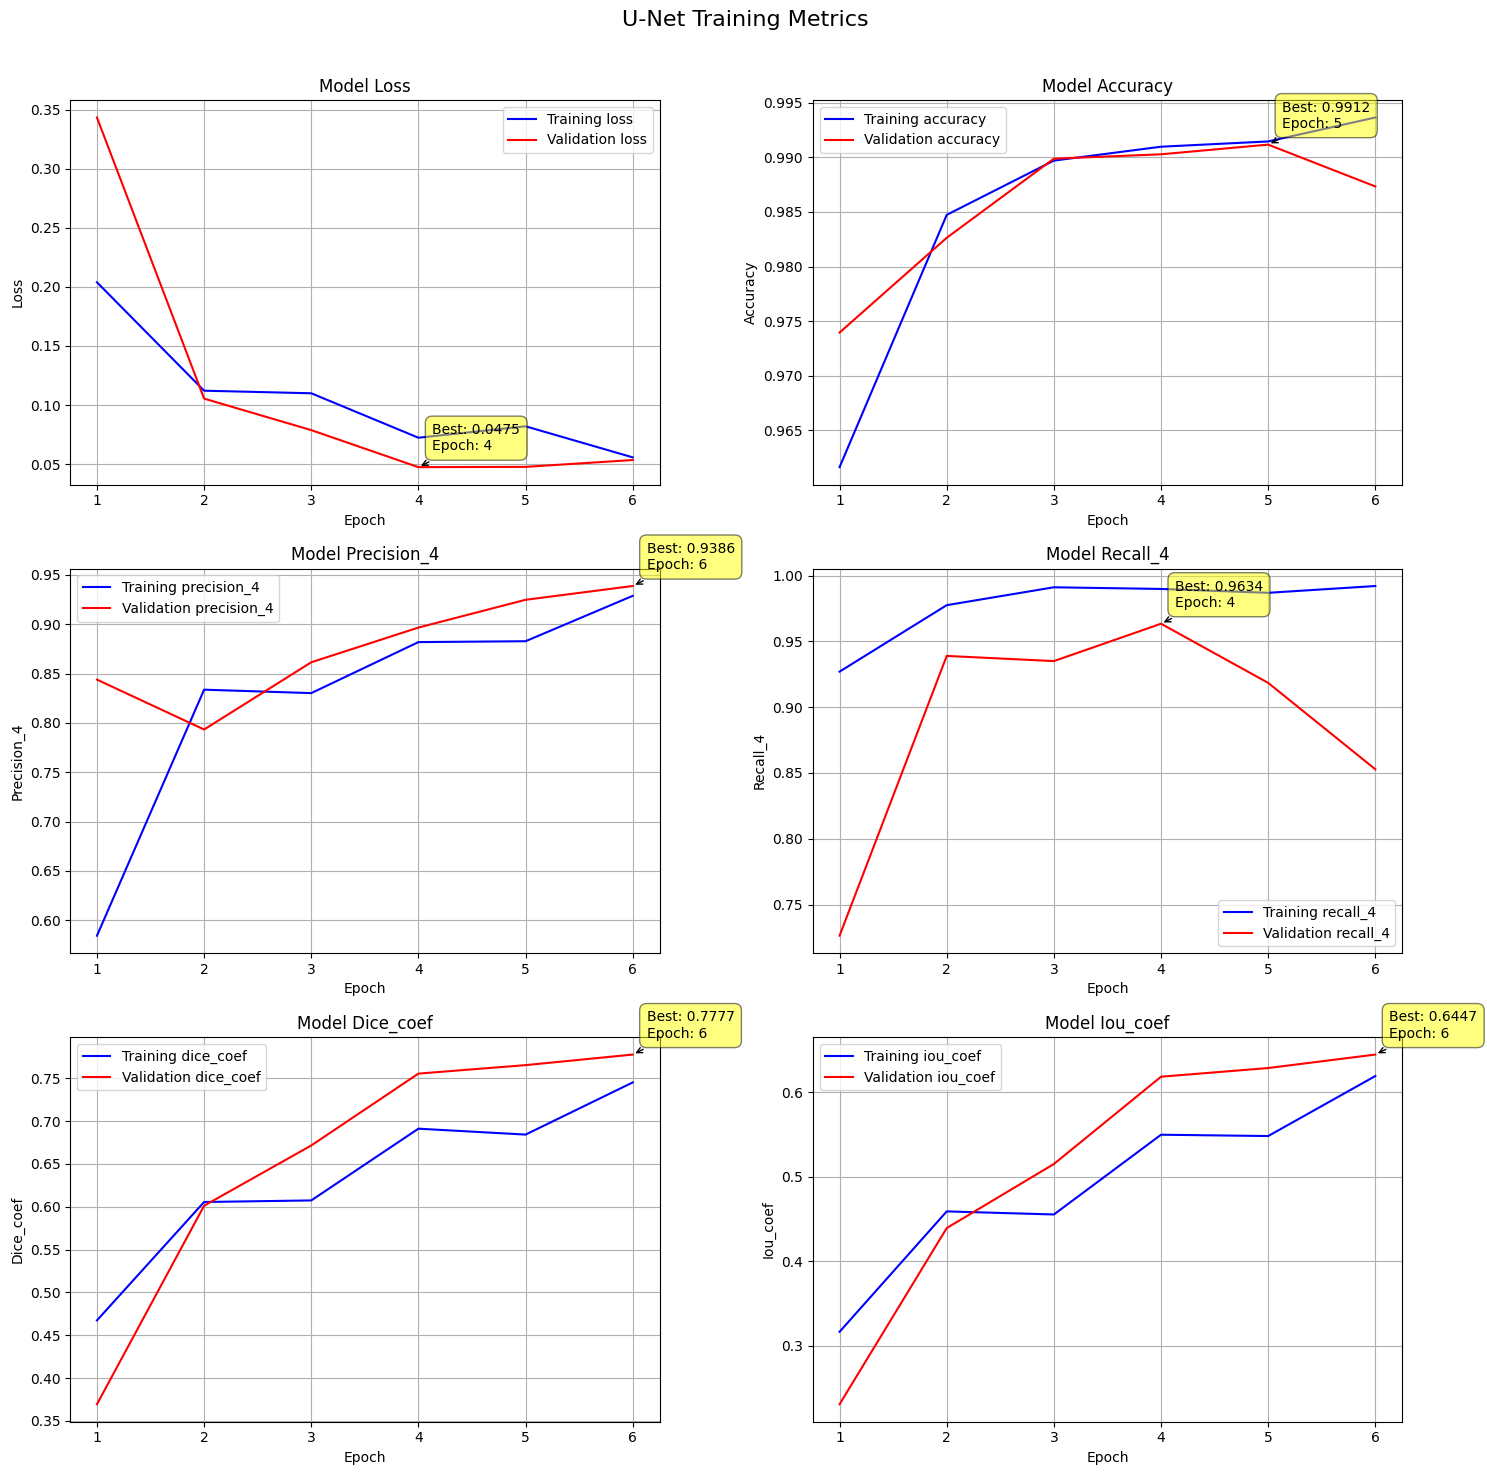

Available metrics in history:
- loss
- accuracy
- precision_4
- recall_4
- dice_coef
- iou_coef
- val_loss
- val_accuracy
- val_precision_4
- val_recall_4
- val_dice_coef
- val_iou_coef
- lr

Best Metrics Summary:
------------------------------------------------------------
Metric               Training        Validation     
------------------------------------------------------------
loss                 0.0558          0.0475         
accuracy             0.9936          0.9912         
precision_4          0.9287          0.9386         
recall_4             0.9920          0.9634         
dice_coef            0.7452          0.7777         
iou_coef             0.6193          0.6447         


In [18]:
import matplotlib.pyplot as plt

# Extract metrics from history
# Make sure to use the metrics that are actually in your history object
metrics = ['loss', 'accuracy', 'precision_4', 'recall_4', 'dice_coef', 'iou_coef']
val_metrics = ['val_' + metric for metric in metrics]

# Create a figure with subplots
plt.style.use('default')
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
fig.suptitle('U-Net Training Metrics', fontsize=16, y=0.98)

# Plot each metric
for i, (metric, val_metric) in enumerate(zip(metrics, val_metrics)):
    row = i // 2
    col = i % 2
    
    # Check if metric exists in history
    if metric in history.history and val_metric in history.history:
        # Get values from history
        train_values = history.history[metric]
        val_values = history.history[val_metric]
        epochs = range(1, len(train_values) + 1)
        
        # Plot
        axes[row, col].plot(epochs, train_values, 'b-', label=f'Training {metric}')
        axes[row, col].plot(epochs, val_values, 'r-', label=f'Validation {metric}')
        
        # Add labels and title
        axes[row, col].set_title(f'Model {metric.capitalize()}')
        axes[row, col].set_xlabel('Epoch')
        axes[row, col].set_ylabel(metric.capitalize())
        axes[row, col].legend()
        axes[row, col].grid(True)
        
        # Add best value annotation
        best_val = max(val_values) if metric != 'loss' else min(val_values)
        best_epoch = val_values.index(best_val) + 1
        axes[row, col].annotate(f'Best: {best_val:.4f}\nEpoch: {best_epoch}',
                               xy=(best_epoch, best_val),
                               xytext=(10, 10),
                               textcoords='offset points',
                               ha='left',
                               va='bottom',
                               bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                               arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    else:
        # If metric doesn't exist, show a message
        axes[row, col].text(0.5, 0.5, f"Metric '{metric}' not found in history",
                           horizontalalignment='center',
                           verticalalignment='center',
                           transform=axes[row, col].transAxes)
        axes[row, col].set_title(f'Missing: {metric.capitalize()}')

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

# Print available metrics for debugging
print("Available metrics in history:")
for key in history.history.keys():
    print(f"- {key}")

# Create a summary table of best metrics
print("\nBest Metrics Summary:")
print("-" * 60)
print(f"{'Metric':<20} {'Training':<15} {'Validation':<15}")
print("-" * 60)
for metric in history.history.keys():
    if not metric.startswith('val_'):
        val_metric = 'val_' + metric
        if val_metric in history.history:
            train_best = max(history.history[metric]) if metric != 'loss' else min(history.history[metric])
            val_best = max(history.history[val_metric]) if metric != 'loss' else min(history.history[val_metric])
            print(f"{metric:<20} {train_best:<15.4f} {val_best:<15.4f}")

HIGH BETA TVERSKY

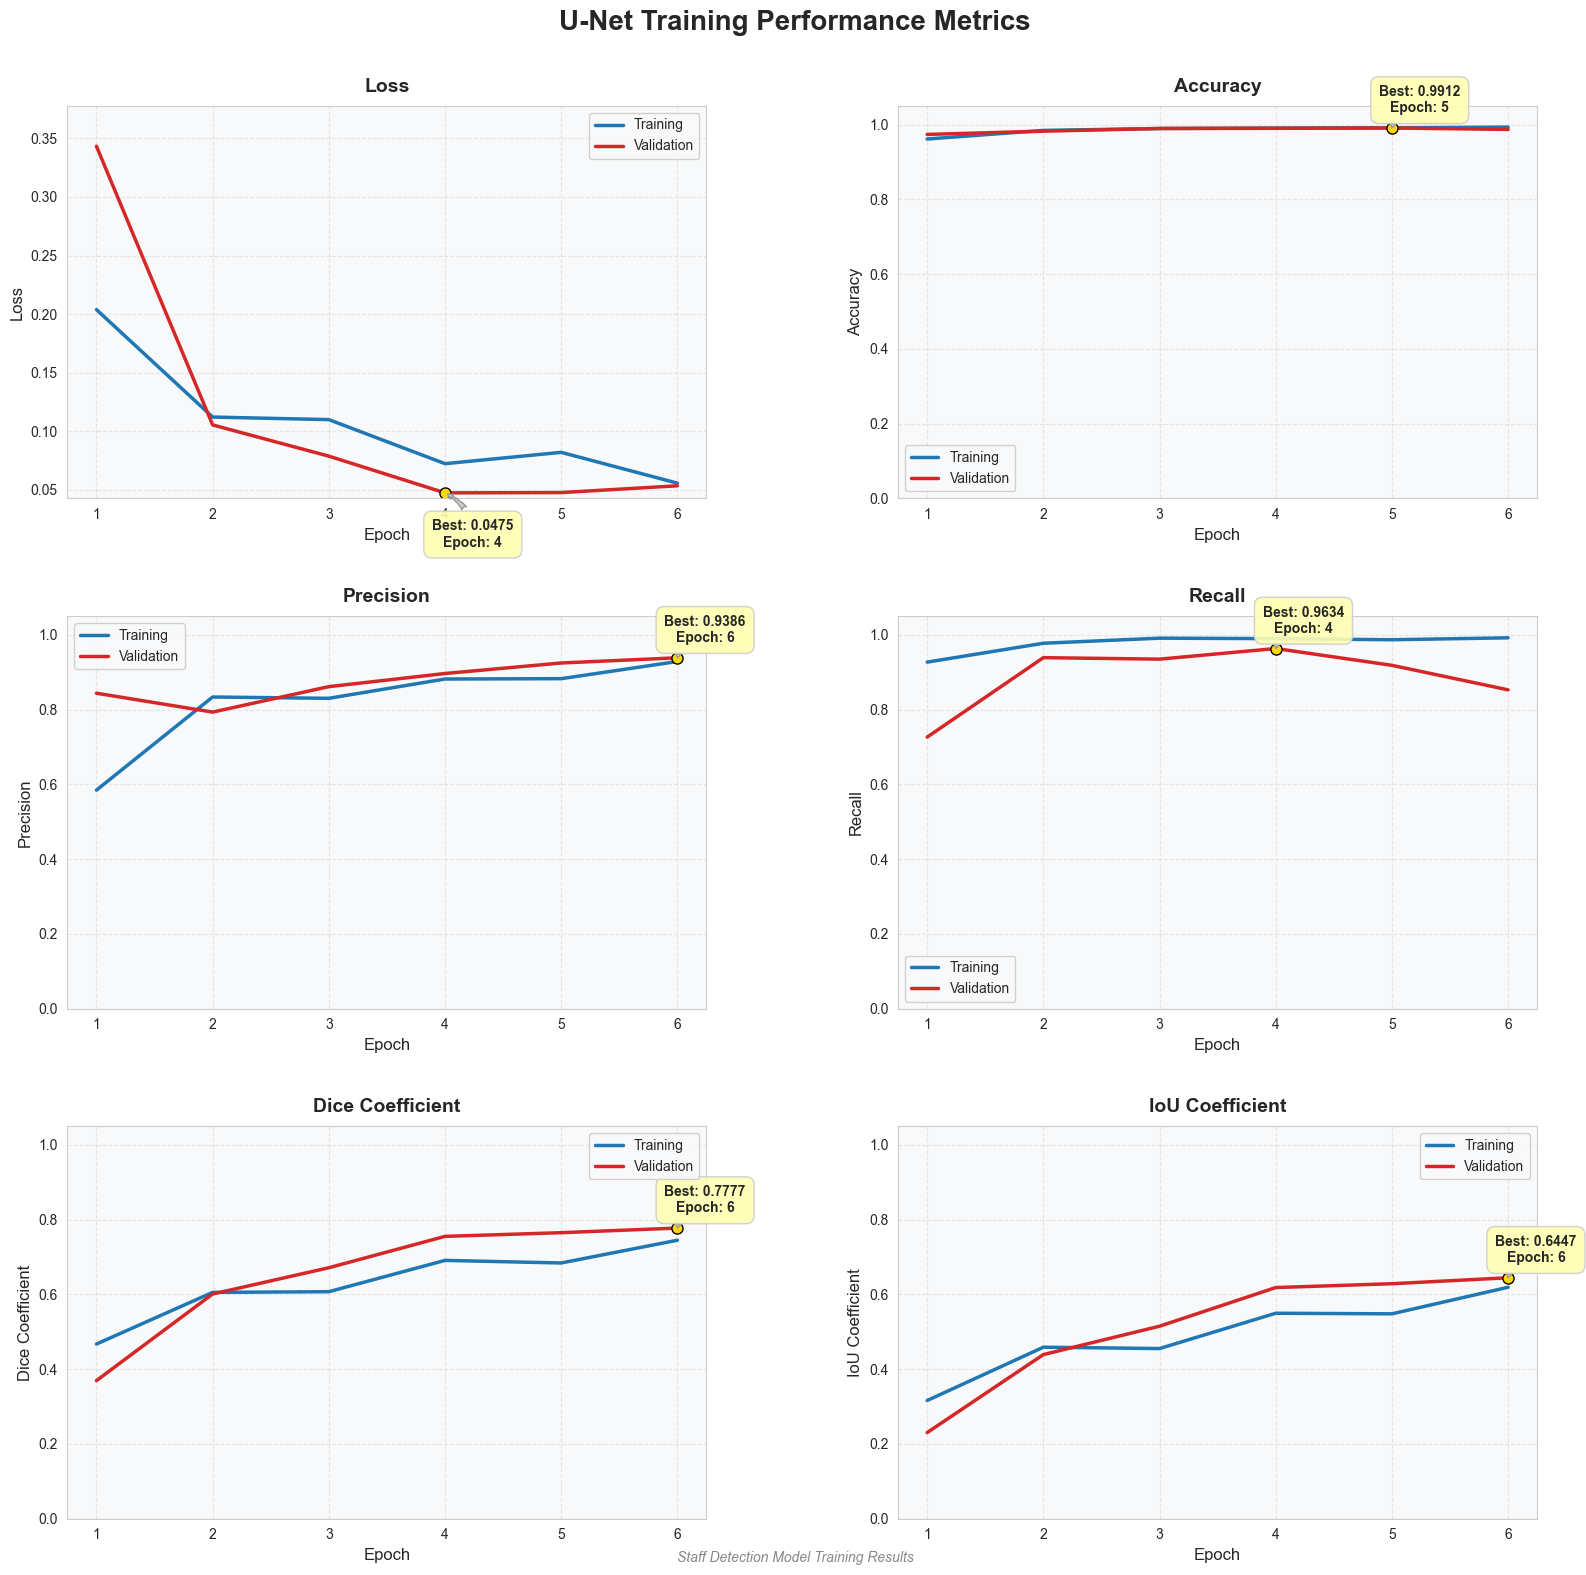


                              TRAINING METRICS SUMMARY

Available metrics in history:
- accuracy (Training and Validation)
- dice_coef (Training and Validation)
- iou_coef (Training and Validation)
- loss (Training and Validation)
- precision (Training and Validation)
- recall (Training and Validation)

Best Metrics Summary:
----------------------------------------------------------------------
Metric                    Training Best        Validation Best     
----------------------------------------------------------------------
Loss                      0.0558               0.0475              
Accuracy                  0.9936               0.9912              
Dice Coef                 0.7452               0.7777              
Iou Coef                  0.6193               0.6447              
Precision                 0.9287               0.9386              
Recall                    0.9920               0.9634              
------------------------------------------------------

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set a more modern style
sns.set_style("whitegrid")
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'DejaVu Sans'],
    'axes.facecolor': '#f8f9fa',
    'figure.facecolor': 'white'
})

# Extract metrics from history
# Make sure to use the metrics that are actually in your history object
metrics = ['loss', 'accuracy', 'precision_4', 'recall_4', 'dice_coef', 'iou_coef']
val_metrics = ['val_' + metric for metric in metrics]
# Display names for the metrics (simplified for precision and recall)
display_names = ['Loss', 'Accuracy', 'Precision', 'Recall', 'Dice Coefficient', 'IoU Coefficient']

# Create a figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(16, 16))
fig.suptitle('U-Net Training Performance Metrics', fontsize=20, y=0.98, fontweight='bold')

# Define colors for consistency
train_color = '#1f77b4'  # Blue
val_color = '#d62728'    # Red
grid_color = '#dddddd'   # Light gray

# Plot each metric
for i, (metric, val_metric, display_name) in enumerate(zip(metrics, val_metrics, display_names)):
    row = i // 2
    col = i % 2
    
    # Check if metric exists in history
    if metric in history.history and val_metric in history.history:
        # Get values from history
        train_values = history.history[metric]
        val_values = history.history[val_metric]
        epochs = range(1, len(train_values) + 1)
        
        # Create a DataFrame for smoother line plotting
        df = pd.DataFrame({
            'Epoch': epochs,
            'Training': train_values,
            'Validation': val_values
        })
        
        # Plot with improved styling
        axes[row, col].plot(df['Epoch'], df['Training'], '-', color=train_color, 
                           linewidth=2.5, label=f'Training')
        axes[row, col].plot(df['Epoch'], df['Validation'], '-', color=val_color, 
                           linewidth=2.5, label=f'Validation')
        
        # Fill area under curves with transparency
        #axes[row, col].fill_between(df['Epoch'], df['Training'], alpha=0.1, color=train_color)
        #axes[row, col].fill_between(df['Epoch'], df['Validation'], alpha=0.1, color=val_color)
        
        # Add labels and title with better formatting - using display name instead of metric
        axes[row, col].set_title(f'{display_name}', fontsize=14, fontweight='bold', pad=10)
        axes[row, col].set_xlabel('Epoch', fontsize=12)
        axes[row, col].set_ylabel(display_name, fontsize=12)
        
        # Improve legend
        axes[row, col].legend(loc='best', frameon=True, framealpha=0.9, fontsize=10)
        
        # Improve grid
        axes[row, col].grid(True, linestyle='--', alpha=0.7, color=grid_color)
        
        # Set better axis limits
        if metric == 'loss':
            y_min = min(min(train_values), min(val_values)) * 0.9
            y_max = max(max(train_values), max(val_values)) * 1.1
            axes[row, col].set_ylim(y_min, y_max)
        else:
            axes[row, col].set_ylim(0, 1.05)
        
        # Add best value annotation with improved styling
        best_val = max(val_values) if metric != 'loss' else min(val_values)
        best_epoch = val_values.index(best_val) + 1
        
        # Create a more attractive annotation box
        axes[row, col].annotate(
            f'Best: {best_val:.4f}\nEpoch: {best_epoch}',
            xy=(best_epoch, best_val),
            xytext=(20, -30 if metric == 'loss' else 20),
            textcoords='offset points',
            ha='center',
            va='center',
            bbox=dict(
                boxstyle='round,pad=0.6',
                fc='#ffffb3',
                ec='#cccccc',
                alpha=0.9
            ),
            arrowprops=dict(
                arrowstyle='fancy',
                connectionstyle='arc3,rad=0.3',
                fc='#cccccc',
                ec='#999999'
            ),
            fontsize=10,
            fontweight='bold'
        )
        
        # Mark the best point
        axes[row, col].plot(best_epoch, best_val, 'o', markersize=8, 
                           markerfacecolor='gold', markeredgecolor='black')
    else:
        # If metric doesn't exist, show a message with better styling
        axes[row, col].text(0.5, 0.5, f"Metric '{display_name}' not found in history",
                           horizontalalignment='center',
                           verticalalignment='center',
                           transform=axes[row, col].transAxes,
                           fontsize=12,
                           fontweight='bold',
                           color='#555555')
        axes[row, col].set_title(f'Missing: {display_name}', fontsize=14)
        axes[row, col].set_facecolor('#f0f0f0')  # Light gray background for missing metrics

plt.tight_layout()
plt.subplots_adjust(top=0.92, hspace=0.3, wspace=0.3)

# Add a watermark or footer
fig.text(0.5, 0.01, 'Staff Detection Model Training Results', 
         ha='center', fontsize=10, color='#888888', style='italic')

# Save the figure with high DPI
plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

# Print available metrics in a more attractive format
print("\n" + "="*80)
print(" "*30 + "TRAINING METRICS SUMMARY")
print("="*80)

print("\nAvailable metrics in history:")
for key in sorted(history.history.keys()):
    if key.startswith('val_'):
        # Clean up display names for the summary too
        display_key = key[4:]
        if display_key == 'precision_4':
            display_key = 'precision'
        elif display_key == 'recall_4':
            display_key = 'recall'
        print(f"- {display_key} (Training and Validation)")

# Create a summary table of best metrics with better formatting
print("\nBest Metrics Summary:")
print("-" * 70)
print(f"{'Metric':<25} {'Training Best':<20} {'Validation Best':<20}")
print("-" * 70)

# Collect metrics for sorted display
metrics_data = []
for metric in history.history.keys():
    if not metric.startswith('val_'):
        val_metric = 'val_' + metric
        if val_metric in history.history:
            train_best = max(history.history[metric]) if metric != 'loss' else min(history.history[metric])
            val_best = max(history.history[val_metric]) if metric != 'loss' else min(history.history[val_metric])
            # Use display name for the metric
            display_metric = metric
            if metric == 'precision_4':
                display_metric = 'precision'
            elif metric == 'recall_4':
                display_metric = 'recall'
            metrics_data.append((display_metric, train_best, val_best))

# Sort metrics with loss first, then alphabetically
metrics_data.sort(key=lambda x: (0 if x[0] == 'loss' else 1, x[0]))

# Print sorted metrics with better formatting
for metric, train_best, val_best in metrics_data:
    metric_name = metric.replace('_', ' ').title()
    print(f"{metric_name:<25} {train_best:<20.4f} {val_best:<20.4f}")

print("-" * 70)
print("\nTraining completed successfully!")

KeyError: 'precision'

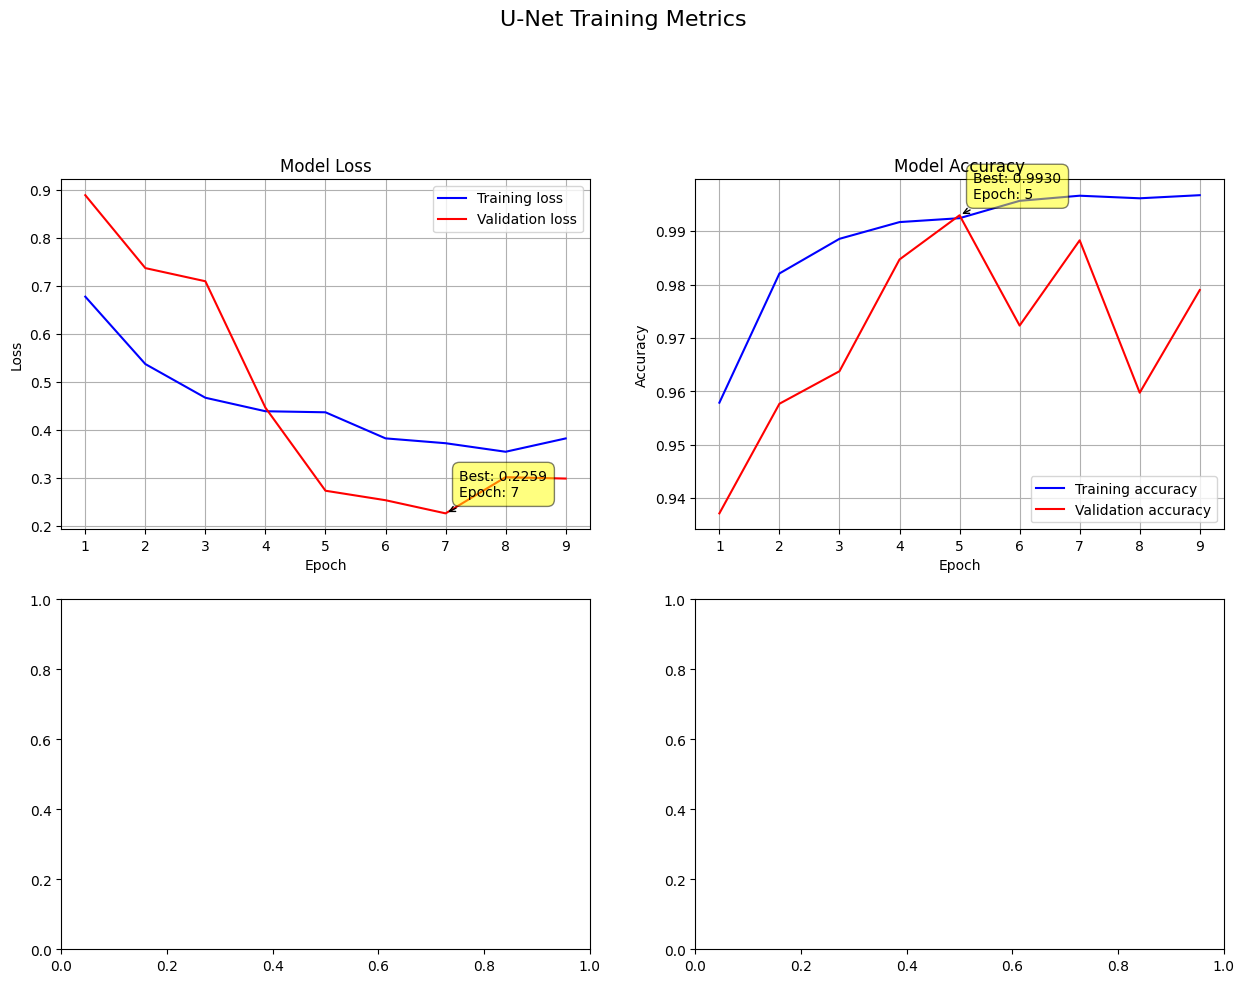

In [8]:
import matplotlib.pyplot as plt

# Extract metrics from history
metrics = ['loss', 'accuracy', 'precision', 'recall']
val_metrics = ['val_' + metric for metric in metrics]

# Create a figure with subplots
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('U-Net Training Metrics', fontsize=16, y=1.05)

# Plot each metric
for i, (metric, val_metric) in enumerate(zip(metrics, val_metrics)):
    row = i // 2
    col = i % 2
    
    # Get values from history
    train_values = history.history[metric]
    val_values = history.history[val_metric]
    epochs = range(1, len(train_values) + 1)
    
    # Plot
    axes[row, col].plot(epochs, train_values, 'b-', label=f'Training {metric}')
    axes[row, col].plot(epochs, val_values, 'r-', label=f'Validation {metric}')
    
    # Add labels and title
    axes[row, col].set_title(f'Model {metric.capitalize()}')
    axes[row, col].set_xlabel('Epoch')
    axes[row, col].set_ylabel(metric.capitalize())
    axes[row, col].legend()
    axes[row, col].grid(True)
    
    # Add best value annotation
    best_val = max(val_values) if metric != 'loss' else min(val_values)
    best_epoch = val_values.index(best_val) + 1
    axes[row, col].annotate(f'Best: {best_val:.4f}\nEpoch: {best_epoch}',
                           xy=(best_epoch, best_val),
                           xytext=(10, 10),
                           textcoords='offset points',
                           ha='left',
                           va='bottom',
                           bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                           arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.tight_layout()
plt.show()

# Create a summary table of best metrics
print("\nBest Metrics Summary:")
print("-" * 50)
print(f"{'Metric':<15} {'Training':<15} {'Validation':<15}")
print("-" * 50)
for metric in metrics:
    train_best = max(history.history[metric]) if metric != 'loss' else min(history.history[metric])
    val_best = max(history.history[f'val_{metric}']) if metric != 'loss' else min(history.history[f'val_{metric}'])
    print(f"{metric:<15} {train_best:<15.4f} {val_best:<15.4f}")

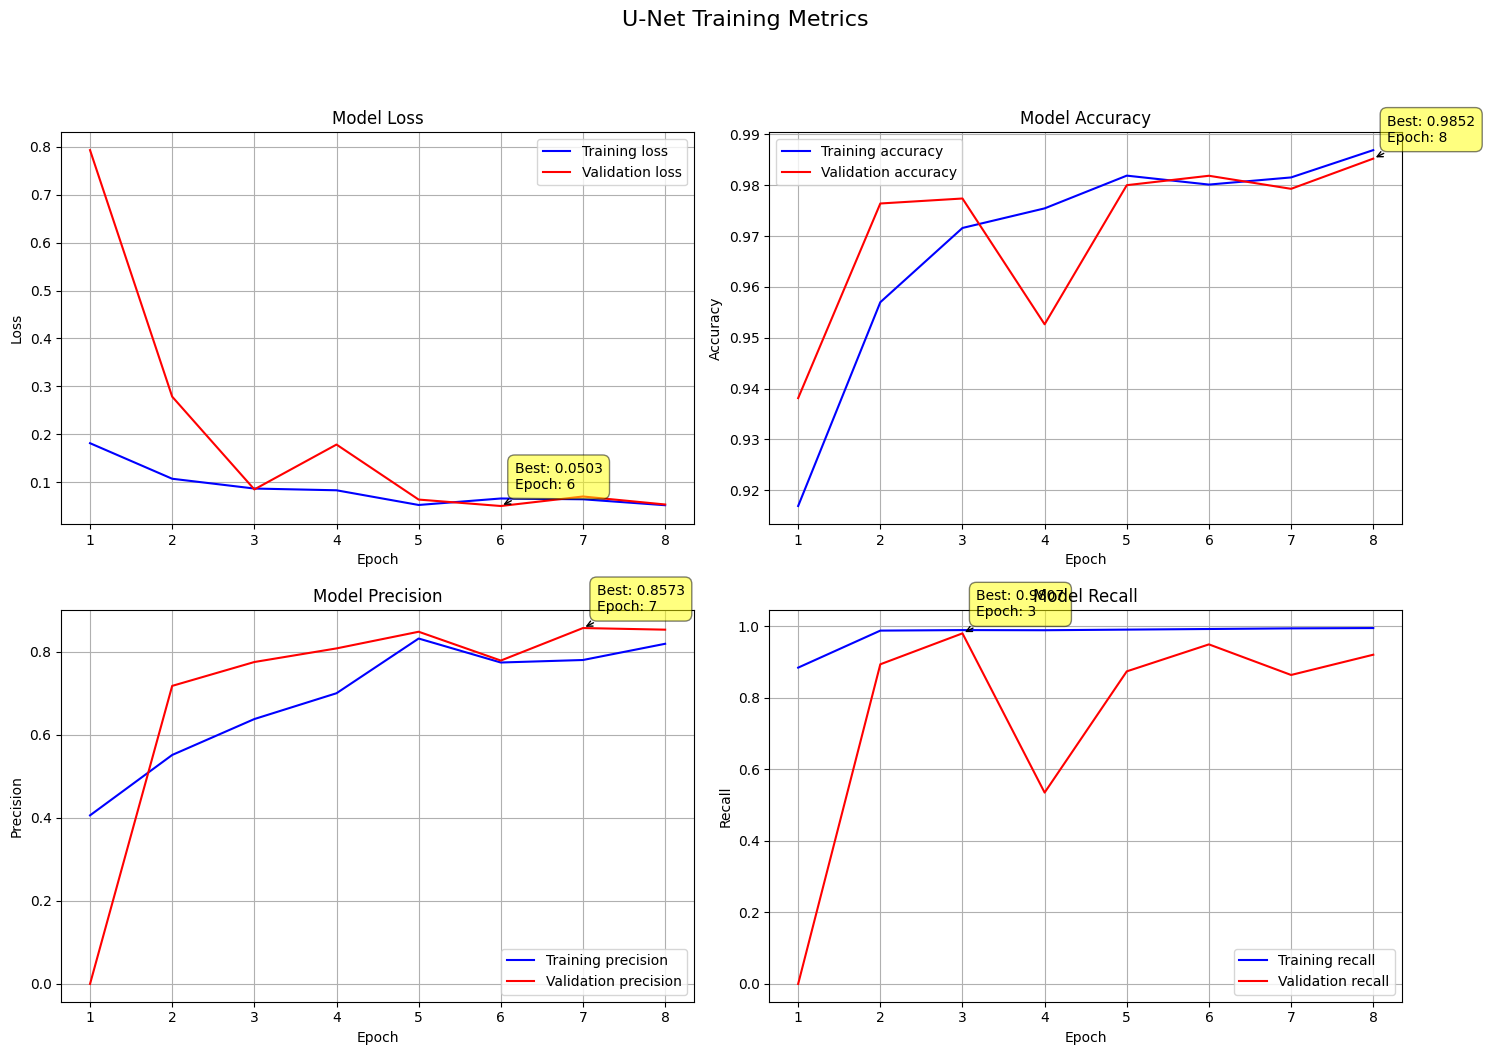


Best Metrics Summary:
--------------------------------------------------
Metric          Training        Validation     
--------------------------------------------------
loss            0.0519          0.0503         
accuracy        0.9869          0.9852         
precision       0.8321          0.8573         
recall          0.9956          0.9807         


In [4]:
import matplotlib.pyplot as plt

# Extract metrics from history
metrics = ['loss', 'accuracy', 'precision', 'recall']
val_metrics = ['val_' + metric for metric in metrics]

# Create a figure with subplots
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('U-Net Training Metrics', fontsize=16, y=1.05)

# Plot each metric
for i, (metric, val_metric) in enumerate(zip(metrics, val_metrics)):
    row = i // 2
    col = i % 2
    
    # Get values from history
    train_values = history.history[metric]
    val_values = history.history[val_metric]
    epochs = range(1, len(train_values) + 1)
    
    # Plot
    axes[row, col].plot(epochs, train_values, 'b-', label=f'Training {metric}')
    axes[row, col].plot(epochs, val_values, 'r-', label=f'Validation {metric}')
    
    # Add labels and title
    axes[row, col].set_title(f'Model {metric.capitalize()}')
    axes[row, col].set_xlabel('Epoch')
    axes[row, col].set_ylabel(metric.capitalize())
    axes[row, col].legend()
    axes[row, col].grid(True)
    
    # Add best value annotation
    best_val = max(val_values) if metric != 'loss' else min(val_values)
    best_epoch = val_values.index(best_val) + 1
    axes[row, col].annotate(f'Best: {best_val:.4f}\nEpoch: {best_epoch}',
                           xy=(best_epoch, best_val),
                           xytext=(10, 10),
                           textcoords='offset points',
                           ha='left',
                           va='bottom',
                           bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                           arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.tight_layout()
plt.show()

# Create a summary table of best metrics
print("\nBest Metrics Summary:")
print("-" * 50)
print(f"{'Metric':<15} {'Training':<15} {'Validation':<15}")
print("-" * 50)
for metric in metrics:
    train_best = max(history.history[metric]) if metric != 'loss' else min(history.history[metric])
    val_best = max(history.history[f'val_{metric}']) if metric != 'loss' else min(history.history[f'val_{metric}'])
    print(f"{metric:<15} {train_best:<15.4f} {val_best:<15.4f}")

HIGH ALPHA

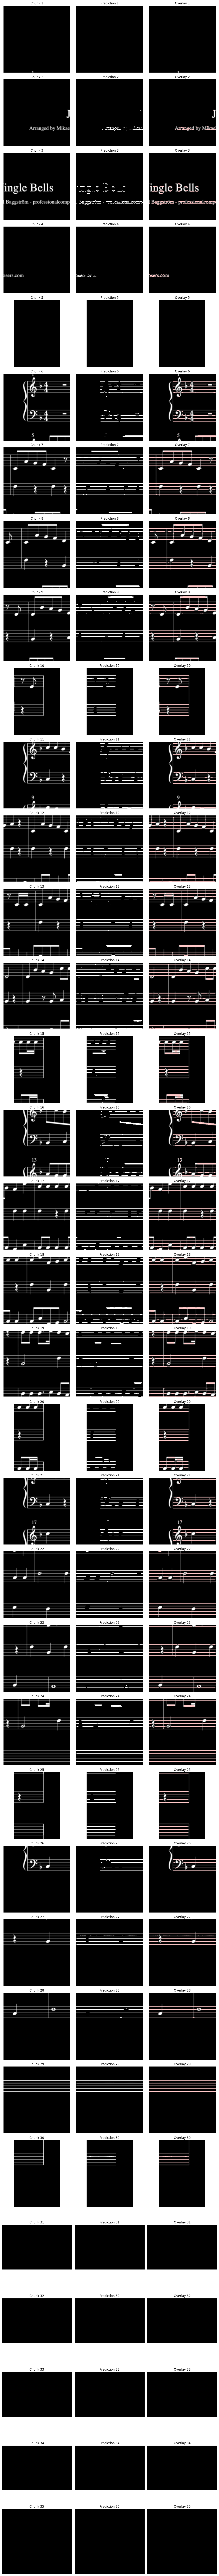

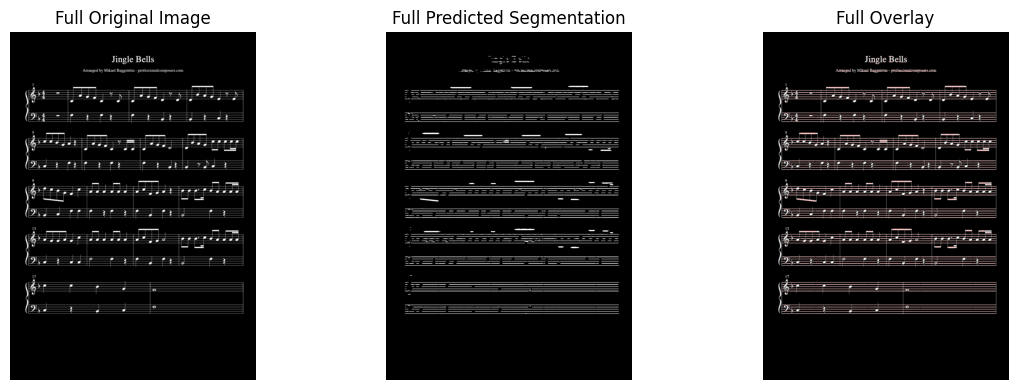

In [19]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


# Function to predict and visualize segmentation
def predict_and_visualize(model, image_path, chunk_size=256):  # Increased from 256 to 512
    # Load image at original size
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    original_height, original_width = img.shape
    
    # Create empty array for predictions
    predictions = np.zeros((original_height, original_width))
    
    # Store chunks and their predictions for visualization
    chunks = []
    chunk_preds = []
    
    # Process image in chunks
    for y in range(0, original_height, chunk_size):
        for x in range(0, original_width, chunk_size):
            # Extract chunk
            chunk = img[y:min(y+chunk_size, original_height), 
                       x:min(x+chunk_size, original_width)]
            
            # Store original chunk
            chunks.append(chunk.copy())
            
            # Pad chunk to chunk_size
            padded = np.zeros((chunk_size, chunk_size))
            padded[:chunk.shape[0], :chunk.shape[1]] = chunk
            chunk = padded
            
            # Preprocess chunk
            chunk = chunk / 255.0
            chunk = np.expand_dims(chunk, axis=[0, -1])
            
            # Predict on chunk
            pred = model.predict(chunk, verbose=0)
            pred = (pred > 0.5).astype(np.uint8)
            pred = np.squeeze(pred)
            
            # Store prediction
            chunk_preds.append(pred[:chunks[-1].shape[0], :chunks[-1].shape[1]])
            
            # Place prediction in correct position
            predictions[y:min(y+chunk_size, original_height),
                      x:min(x+chunk_size, original_width)] = \
                pred[:min(original_height-y, chunk_size),
                     :min(original_width-x, chunk_size)]
    
    # Display chunks and their predictions
    n_chunks = len(chunks)
    n_cols = 3  # Original, Prediction, Overlay for each chunk
    n_rows = n_chunks
    plt.figure(figsize=(12, 4*n_rows))
    
    for i in range(n_chunks):
        # Original chunk
        plt.subplot(n_rows, n_cols, i*n_cols + 1)
        plt.imshow(chunks[i], cmap='gray')
        plt.title(f'Chunk {i+1}')
        plt.axis('off')
        
        # Predicted segmentation
        plt.subplot(n_rows, n_cols, i*n_cols + 2)
        plt.imshow(chunk_preds[i] * 255, cmap='gray')
        plt.title(f'Prediction {i+1}')
        plt.axis('off')
        
        # Overlay with red tint
        overlay = np.zeros((chunks[i].shape[0], chunks[i].shape[1], 3), dtype=np.uint8)
        overlay[..., 0] = chunks[i]  # Red channel
        overlay[..., 1] = chunks[i]  # Green channel
        overlay[..., 2] = chunks[i]  # Blue channel
        
        # Add red tint to predicted areas
        overlay[chunk_preds[i] == 1] = [255, 200, 200]  # Light red color
        
        plt.subplot(n_rows, n_cols, i*n_cols + 3)
        plt.imshow(overlay)
        plt.title(f'Overlay {i+1}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Display final combined result
    pred_viz = predictions * 255
    original_viz = img.copy()
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(131)
    plt.imshow(original_viz, cmap='gray')
    plt.title('Full Original Image')
    plt.axis('off')
    
    plt.subplot(132)
    plt.imshow(pred_viz, cmap='gray')
    plt.title('Full Predicted Segmentation')
    plt.axis('off')
    
    # Create colored overlay for full image
    full_overlay = np.zeros((original_height, original_width, 3), dtype=np.uint8)
    full_overlay[..., 0] = original_viz  # Red channel
    full_overlay[..., 1] = original_viz  # Green channel 
    full_overlay[..., 2] = original_viz  # Blue channel
    
    # Add red tint to predicted areas
    full_overlay[predictions == 1] = [255, 200, 200]  # Light red color
    
    plt.subplot(133)
    plt.imshow(full_overlay)
    plt.title('Full Overlay')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Test prediction on a sample image
sample_image_path = 'Jingle-Bells-Free-Sheet-Music-1200x1699.png'  # Replace with actual test image path
# Invert colors before prediction
img = cv2.imread(sample_image_path, cv2.IMREAD_GRAYSCALE)
img = 255 - img  # Invert black and white
cv2.imwrite('inverted_' + sample_image_path, img)
predict_and_visualize(unet_model, 'inverted_' + sample_image_path)


HIGH BETA

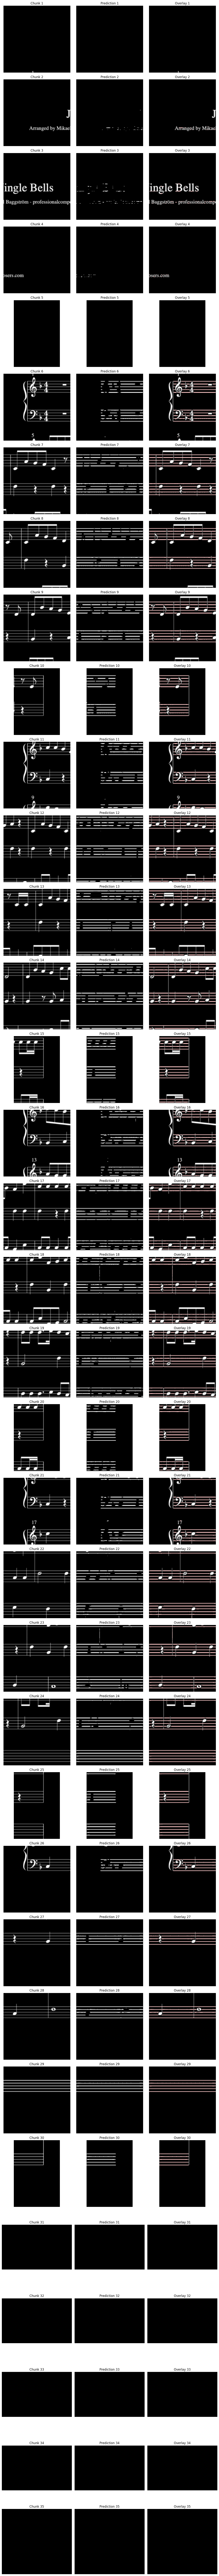

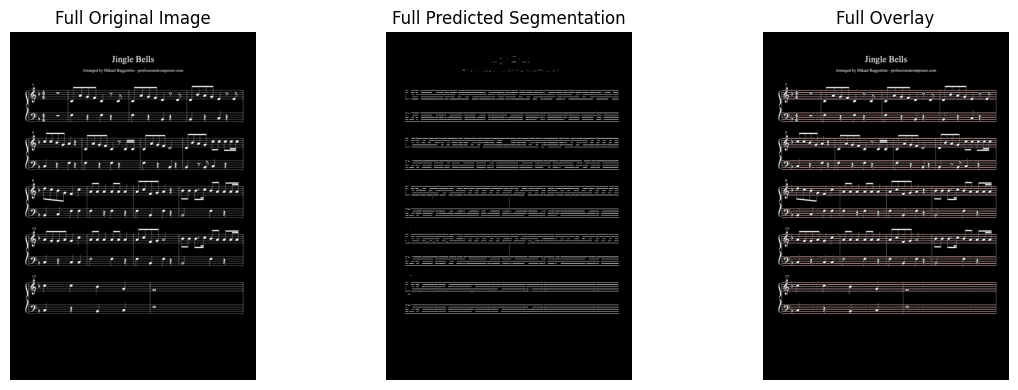

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


# Function to predict and visualize segmentation
def predict_and_visualize(model, image_path, chunk_size=256):  # Increased from 256 to 512
    # Load image at original size
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    original_height, original_width = img.shape
    
    # Create empty array for predictions
    predictions = np.zeros((original_height, original_width))
    
    # Store chunks and their predictions for visualization
    chunks = []
    chunk_preds = []
    
    # Process image in chunks
    for y in range(0, original_height, chunk_size):
        for x in range(0, original_width, chunk_size):
            # Extract chunk
            chunk = img[y:min(y+chunk_size, original_height), 
                       x:min(x+chunk_size, original_width)]
            
            # Store original chunk
            chunks.append(chunk.copy())
            
            # Pad chunk to chunk_size
            padded = np.zeros((chunk_size, chunk_size))
            padded[:chunk.shape[0], :chunk.shape[1]] = chunk
            chunk = padded
            
            # Preprocess chunk
            chunk = chunk / 255.0
            chunk = np.expand_dims(chunk, axis=[0, -1])
            
            # Predict on chunk
            pred = model.predict(chunk, verbose=0)
            pred = (pred > 0.5).astype(np.uint8)
            pred = np.squeeze(pred)
            
            # Store prediction
            chunk_preds.append(pred[:chunks[-1].shape[0], :chunks[-1].shape[1]])
            
            # Place prediction in correct position
            predictions[y:min(y+chunk_size, original_height),
                      x:min(x+chunk_size, original_width)] = \
                pred[:min(original_height-y, chunk_size),
                     :min(original_width-x, chunk_size)]
    
    # Display chunks and their predictions
    n_chunks = len(chunks)
    n_cols = 3  # Original, Prediction, Overlay for each chunk
    n_rows = n_chunks
    plt.figure(figsize=(12, 4*n_rows))
    
    for i in range(n_chunks):
        # Original chunk
        plt.subplot(n_rows, n_cols, i*n_cols + 1)
        plt.imshow(chunks[i], cmap='gray')
        plt.title(f'Chunk {i+1}')
        plt.axis('off')
        
        # Predicted segmentation
        plt.subplot(n_rows, n_cols, i*n_cols + 2)
        plt.imshow(chunk_preds[i] * 255, cmap='gray')
        plt.title(f'Prediction {i+1}')
        plt.axis('off')
        
        # Overlay with red tint
        overlay = np.zeros((chunks[i].shape[0], chunks[i].shape[1], 3), dtype=np.uint8)
        overlay[..., 0] = chunks[i]  # Red channel
        overlay[..., 1] = chunks[i]  # Green channel
        overlay[..., 2] = chunks[i]  # Blue channel
        
        # Add red tint to predicted areas
        overlay[chunk_preds[i] == 1] = [255, 200, 200]  # Light red color
        
        plt.subplot(n_rows, n_cols, i*n_cols + 3)
        plt.imshow(overlay)
        plt.title(f'Overlay {i+1}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Display final combined result
    pred_viz = predictions * 255
    original_viz = img.copy()
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(131)
    plt.imshow(original_viz, cmap='gray')
    plt.title('Full Original Image')
    plt.axis('off')
    
    plt.subplot(132)
    plt.imshow(pred_viz, cmap='gray')
    plt.title('Full Predicted Segmentation')
    plt.axis('off')
    
    # Create colored overlay for full image
    full_overlay = np.zeros((original_height, original_width, 3), dtype=np.uint8)
    full_overlay[..., 0] = original_viz  # Red channel
    full_overlay[..., 1] = original_viz  # Green channel 
    full_overlay[..., 2] = original_viz  # Blue channel
    
    # Add red tint to predicted areas
    full_overlay[predictions == 1] = [255, 200, 200]  # Light red color
    
    plt.subplot(133)
    plt.imshow(full_overlay)
    plt.title('Full Overlay')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Test prediction on a sample image
sample_image_path = 'Jingle-Bells-Free-Sheet-Music-1200x1699.png'  # Replace with actual test image path
# Invert colors before prediction
img = cv2.imread(sample_image_path, cv2.IMREAD_GRAYSCALE)
img = 255 - img  # Invert black and white
cv2.imwrite('inverted_' + sample_image_path, img)
predict_and_visualize(unet_model, 'inverted_' + sample_image_path)


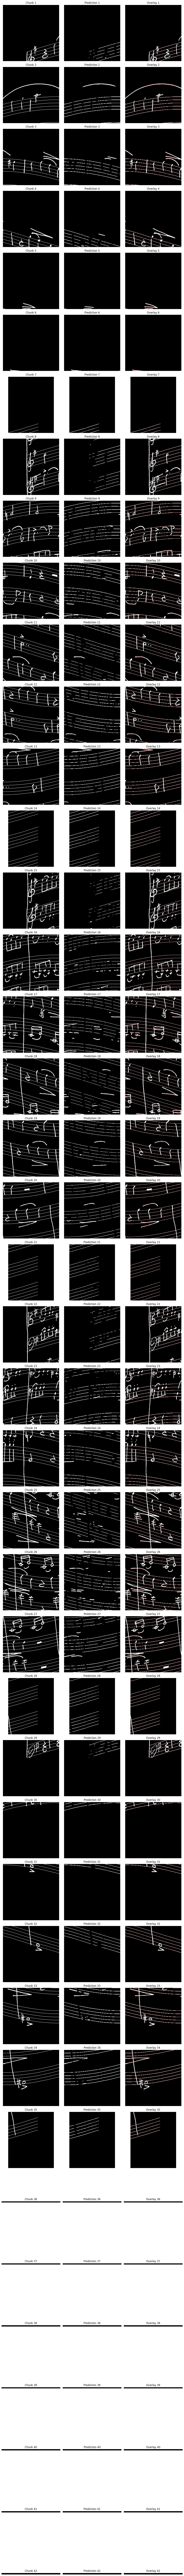

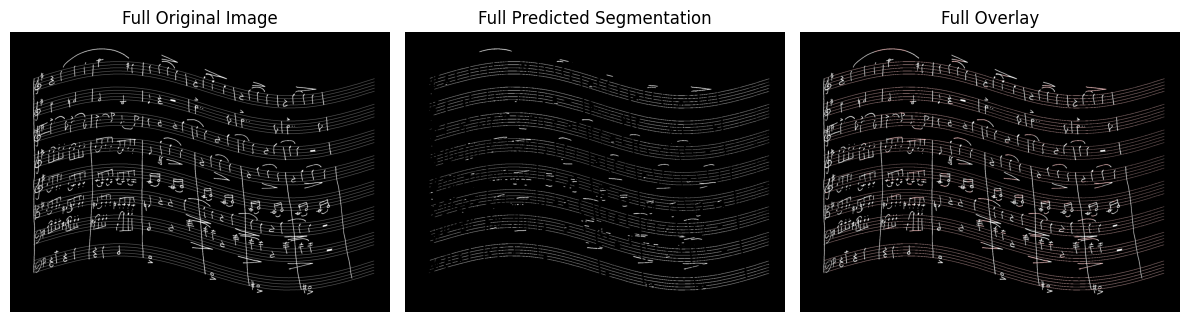

In [12]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


# Function to predict and visualize segmentation
def predict_and_visualize(model, image_path, chunk_size=256):  # Increased from 256 to 512
    # Load image and resize to half size
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img.shape[1]//2, img.shape[0]//2))  # Resize to half
    original_height, original_width = img.shape
    
    # Create empty array for predictions
    predictions = np.zeros((original_height, original_width))
    
    # Store chunks and their predictions for visualization
    chunks = []
    chunk_preds = []
    
    # Process image in chunks
    for y in range(0, original_height, chunk_size):
        for x in range(0, original_width, chunk_size):
            # Extract chunk
            chunk = img[y:min(y+chunk_size, original_height), 
                       x:min(x+chunk_size, original_width)]
            
            # Store original chunk
            chunks.append(chunk.copy())
            
            # Pad chunk to chunk_size
            padded = np.zeros((chunk_size, chunk_size))
            padded[:chunk.shape[0], :chunk.shape[1]] = chunk
            chunk = padded
            
            # Preprocess chunk
            chunk = chunk / 255.0
            chunk = np.expand_dims(chunk, axis=[0, -1])
            
            # Predict on chunk
            pred = model.predict(chunk, verbose=0)
            pred = (pred > 0.5).astype(np.uint8)
            pred = np.squeeze(pred)
            
            # Store prediction
            chunk_preds.append(pred[:chunks[-1].shape[0], :chunks[-1].shape[1]])
            
            # Place prediction in correct position
            predictions[y:min(y+chunk_size, original_height),
                      x:min(x+chunk_size, original_width)] = \
                pred[:min(original_height-y, chunk_size),
                     :min(original_width-x, chunk_size)]
    
    # Display chunks and their predictions
    n_chunks = len(chunks)
    n_cols = 3  # Original, Prediction, Overlay for each chunk
    n_rows = n_chunks
    plt.figure(figsize=(12, 4*n_rows))
    
    for i in range(n_chunks):
        # Original chunk
        plt.subplot(n_rows, n_cols, i*n_cols + 1)
        plt.imshow(chunks[i], cmap='gray')
        plt.title(f'Chunk {i+1}')
        plt.axis('off')
        
        # Predicted segmentation
        plt.subplot(n_rows, n_cols, i*n_cols + 2)
        plt.imshow(chunk_preds[i] * 255, cmap='gray')
        plt.title(f'Prediction {i+1}')
        plt.axis('off')
        
        # Overlay with red tint
        overlay = np.zeros((chunks[i].shape[0], chunks[i].shape[1], 3), dtype=np.uint8)
        overlay[..., 0] = chunks[i]  # Red channel
        overlay[..., 1] = chunks[i]  # Green channel
        overlay[..., 2] = chunks[i]  # Blue channel
        
        # Add red tint to predicted areas
        overlay[chunk_preds[i] == 1] = [255, 200, 200]  # Light red color
        
        plt.subplot(n_rows, n_cols, i*n_cols + 3)
        plt.imshow(overlay)
        plt.title(f'Overlay {i+1}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Display final combined result
    pred_viz = predictions * 255
    original_viz = img.copy()
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(131)
    plt.imshow(original_viz, cmap='gray')
    plt.title('Full Original Image')
    plt.axis('off')
    
    plt.subplot(132)
    plt.imshow(pred_viz, cmap='gray')
    plt.title('Full Predicted Segmentation')
    plt.axis('off')
    
    # Create colored overlay for full image
    full_overlay = np.zeros((original_height, original_width, 3), dtype=np.uint8)
    full_overlay[..., 0] = original_viz  # Red channel
    full_overlay[..., 1] = original_viz  # Green channel 
    full_overlay[..., 2] = original_viz  # Blue channel
    
    # Add red tint to predicted areas
    full_overlay[predictions == 1] = [255, 200, 200]  # Light red color
    
    plt.subplot(133)
    plt.imshow(full_overlay)
    plt.title('Full Overlay')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Test prediction on a sample image
sample_image_path = 'CvcMuscima-Distortions/curvature/w-25/image/p016.png'  # Replace with actual test image path
img = cv2.imread(sample_image_path, cv2.IMREAD_GRAYSCALE)
predict_and_visualize(unet_model, sample_image_path)


TRY MODEL WITH 

In [ ]:
# Import required libraries
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.backend as K
import numpy as np
from PIL import Image
import os
import math
import matplotlib.pyplot as plt
import random
import cv2
# Check for GPU availability and configure
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print('GPU is available and configured')
else:
    print('No GPU found, running on CPU')
    
def dice_loss(y_true, y_pred):
    """
    Dice loss for binary segmentation.
    Modified to penalize false positives more heavily.
    """
    smooth = 1.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    
    # Add penalty term for false positives
    false_positives = K.sum((1 - y_true_f) * y_pred_f)
    fp_weight = 2.0  # Weight for false positive penalty
    
    dice = (2.0 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    fp_penalty = false_positives / (K.sum(1 - y_true_f) + smooth)
    
    return 1.0 - dice + fp_weight * fp_penalty

def weighted_dice_loss(y_true, y_pred):
    """
    Weighted Dice loss for binary segmentation with class imbalance handling.
    """
    smooth = 1.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    # Calculate class weights based on frequency
    pos_weight = 10.0  # Weight for positive class (staff lines)
    neg_weight = 1.0   # Weight for negative class (background)
    
    # Apply weights
    weighted_y_true = y_true_f * pos_weight + (1 - y_true_f) * neg_weight
    
    intersection = K.sum(y_true_f * y_pred_f * weighted_y_true)
    union = K.sum(y_true_f * weighted_y_true) + K.sum(y_pred_f * weighted_y_true)
    
    dice = (2.0 * intersection + smooth) / (union + smooth)
    
    return 1.0 - dice

def build_unet(input_size=(256, 256, 1)):  # Reduced input size
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    conv3 = Dropout(0.3)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    # Bridge
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(conv4)
    conv4 = tf.keras.layers.BatchNormalization()(conv4)
    drop4 = Dropout(0.3)(conv4)  # Increased dropout rate
    
    # Decoder
    up5 = Conv2DTranspose(128, 2, strides=(2,2), padding='same')(drop4)
    merge5 = concatenate([conv3, up5])
    conv5 = Conv2D(128, 3, activation='relu', padding='same')(merge5)
    conv5 = Conv2D(128, 3, activation='relu', padding='same')(conv5)
    conv5 = tf.keras.layers.BatchNormalization()(conv5)
    conv5 = Dropout(0.3)(conv5) 
    
    up6 = Conv2DTranspose(64, 2, strides=(2,2), padding='same')(conv5)
    merge6 = concatenate([conv2, up6])
    conv6 = Conv2D(64, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(64, 3, activation='relu', padding='same')(conv6)
    conv6 = tf.keras.layers.BatchNormalization()(conv6)
    conv6 = Dropout(0.3)(conv6)
    
    up7 = Conv2DTranspose(32, 2, strides=(2,2), padding='same')(conv6)
    merge7 = concatenate([conv1, up7])
    conv7 = Conv2D(32, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(32, 3, activation='relu', padding='same')(conv7)
    conv7 = tf.keras.layers.BatchNormalization()(conv7)
    
    # Final layer with lower initial bias
    outputs = Conv2D(1, 1, activation='sigmoid', bias_initializer=tf.keras.initializers.Constant(-2.0))(conv7)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

def get_sliding_chunks(img_array, chunk_size=(256, 256), stride=128):
    """Get all possible sliding window chunks from image with given stride"""
    height, width = img_array.shape
    chunks = []
    positions = []
    
    for h in range(0, height - chunk_size[0] + 1, stride):
        for w in range(0, width - chunk_size[1] + 1, stride):
            chunk = img_array[h:h + chunk_size[0], w:w + chunk_size[1]]
            chunks.append(chunk)
            positions.append((h, w))
            
    # Handle edge cases
    # Right edge
    if width % stride != 0:
        for h in range(0, height - chunk_size[0] + 1, stride):
            w = width - chunk_size[1]
            chunk = img_array[h:h + chunk_size[0], w:w + chunk_size[1]]
            chunks.append(chunk)
            positions.append((h, w))
            
    # Bottom edge
    if height % stride != 0:
        for w in range(0, width - chunk_size[1] + 1, stride):
            h = height - chunk_size[0]
            chunk = img_array[h:h + chunk_size[0], w:w + chunk_size[1]]
            chunks.append(chunk)
            positions.append((h, w))
            
    # Bottom-right corner
    if height % stride != 0 and width % stride != 0:
        h = height - chunk_size[0]
        w = width - chunk_size[1]
        chunk = img_array[h:h + chunk_size[0], w:w + chunk_size[1]]
        chunks.append(chunk)
        positions.append((h, w))
    
    return chunks, positions

def preprocess_data_generator(data_paths, batch_size=16, chunk_size=(256, 256), stride=128):
    while True:
        np.random.shuffle(data_paths)
        
        X_batch = []
        y_batch = []
        
        for img_path, staff_path in data_paths:
            # Load and resize images
            img = Image.open(img_path).convert('L')
            staff = Image.open(staff_path).convert('L')
            
            #img = resize_image_with_augmentation(img)
            staff = staff.resize(img.size)
            
            # Apply contrast enhancement to input images
            img_array = np.array(img)
            img_array = cv2.equalizeHist(img_array)
            img = Image.fromarray(img_array)
            
            img = np.array(img) / 255.0
            staff = (np.array(staff) > 128).astype(np.float32)
            
            img_chunks, positions = get_sliding_chunks(img, chunk_size, stride)
            staff_chunks, _ = get_sliding_chunks(staff, chunk_size, stride)
            
            # Debug: Count empty vs non-empty chunks
            empty_chunks = 0
            non_empty_chunks = 0
            
            for img_chunk, staff_chunk in zip(img_chunks, staff_chunks):
                # Increase threshold for what counts as a non-empty chunk
                staff_pixel_percentage = np.mean(staff_chunk) * 100  # Convert to percentage
                
                # Only add chunks that contain sufficient staff lines
                if staff_pixel_percentage > 5.0:  # Increased from 1% to 1.5%
                    X_batch.append(img_chunk)
                    y_batch.append(staff_chunk)
                    non_empty_chunks += 1
                else:
                    empty_chunks += 1
                    
                    # Add a small percentage of empty chunks to help model learn background
                    if random.random() < 0.05:  # Only keep 5% of empty chunks
                        X_batch.append(img_chunk)
                        y_batch.append(staff_chunk)
                
                if len(X_batch) == batch_size:
                    # Print debug info occasionally
                    if random.random() < 0.01:  # 1% chance to print stats
                        print(f"Batch stats: {non_empty_chunks} non-empty chunks, {empty_chunks} empty chunks skipped")
                        
                    yield (np.array(X_batch)[..., np.newaxis],
                          np.array(y_batch)[..., np.newaxis])
                    X_batch = []
                    y_batch = []
            
            # Check if we have a partial batch at the end of each image
            if len(X_batch) > 0:
                yield (np.array(X_batch)[..., np.newaxis],
                      np.array(y_batch)[..., np.newaxis])
                X_batch = []
                y_batch = []

print("Starting training process...")

# Training parameters - reduced for faster training
BATCH_SIZE = 16  # Increased batch size
STRIDE = 128  # Reduced stride
MAX_IMAGES_PER_EPOCH = 100  # Reduced images per epoch
VALIDATION_IMAGES = 150  # Reduced validation images

train_generator = preprocess_data_generator(
    train_paths, 
    BATCH_SIZE,
    chunk_size=(256, 256),  # Reduced chunk size
    stride=STRIDE
)
val_generator = preprocess_data_generator(
    val_paths, 
    BATCH_SIZE,
    chunk_size=(256, 256),
    stride=STRIDE
)

# Calculate average number of chunks per image based on smaller image size
AVG_IMAGE_SIZE = (1750, 1250)  # Reduced typical size
CHUNKS_PER_IMAGE = ((AVG_IMAGE_SIZE[0] - 256) // STRIDE + 1) * ((AVG_IMAGE_SIZE[1] - 256) // STRIDE + 1)

STEPS_PER_EPOCH = (CHUNKS_PER_IMAGE * MAX_IMAGES_PER_EPOCH) // BATCH_SIZE
VALIDATION_STEPS = (CHUNKS_PER_IMAGE * VALIDATION_IMAGES) // BATCH_SIZE

print(f"Estimated chunks per image: {CHUNKS_PER_IMAGE}")
print(f"Steps per epoch: {STEPS_PER_EPOCH}")
print(f"Validation steps: {VALIDATION_STEPS}")

print("\nBuilding U-Net model...")
unet_model = build_unet(input_size=(256, 256, 1))  # Reduced input size
unet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  
    loss=weighted_dice_loss,
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

print("\nSetting up callbacks...")
class MetricsPrinter(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"\nEpoch {epoch+1}:")
        for metric, value in logs.items():
            print(f"{metric}: {value:.4f}")

checkpoint = ModelCheckpoint(
    'test_unet_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=1,  # Reduced patience
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=1,  # Reduced patience
    min_lr=1e-6,
    verbose=1
)

metrics_printer = MetricsPrinter()

callbacks = [checkpoint, early_stopping, reduce_lr, metrics_printer]

print("\nStarting model training...")
print("Training will run for 15 epochs with early stopping...")
history = unet_model.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    epochs=15,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")
print("Saving final model...")
unet_model.save('finaltest_unet_modelweighted.h5')
print("Model saved successfully as 'final_unet_modelweighted.h5'")
